# **Client Churn prediction**

**The company is a bank** that operates primarily in Europe. **Their main product is a bank account** which clients can keep their salary and make payments. Owning this account **doesn't have any cost in the first 12 months**. However, the client needs to **rehire the bank** for the upcoming 12 months **after the free trial expires** as well as **everytime this new 12 months hired also expires**. Recently, the Analytics team noticed that the ***churn rate* of clients is *steadily increasing***

Financial data is based on **client's Estimated Salary** and it is yearly based:
- Clients above average: *returns **3%** of their Estimated Salary*
- Clients below average: *returns **5%** of their Estimated Salary*

Worried about this new growing rate of churn clients, the **Data Science team has the challenge to create an action plan to reduce the churn rate of clients and show the financial return of the initiative**. Clients that **don't rehire the bank** after the free trial or after their last renovation **are considered churn**

The **business and marketing plan to keep clients** is to offer a **discount cupom** to incentive clients stay at the bank and the **budget is \\$10.000,00**. Therefore, the **Data Science team** needs to **develop a Machine Learning model to predict potencial churns** and **then choose a business strategy** to offer discounts that **maximaze ROI - Return on investmemt** 

>*Disclaimer: this is a fictional business case*



# 0.0 Imports

In [1]:
#Import libraries

import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import missingno                   as mnso
import shap
import hyperopt
from hyperopt                      import hp
from matplotlib.gridspec           import GridSpec
from matplotlib.figure             import Figure
from IPython.core.display          import Image, HTML
from scipy                         import stats                         as ss
from imblearn.combine              import SMOTETomek 
from boruta                        import BorutaPy
from BorutaShap                    import BorutaShap, load_data
from xgboost                       import XGBClassifier, DMatrix
from sklearn.experimental          import enable_iterative_imputer
from sklearn.impute                import KNNImputer,IterativeImputer
from sklearn.preprocessing         import StandardScaler, MinMaxScaler
from sklearn.model_selection       import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble              import RandomForestClassifier
from sklearn.metrics               import classification_report
from sklearn.multiclass            import OneVsRestClassifier
from catboost                      import CatBoostClassifier, Pool, EFstrType
from sklearn.linear_model          import LogisticRegression
from sklearn.svm                   import SVC
from yellowbrick.classifier        import ROCAUC, ClassificationReport, ConfusionMatrix, ClassPredictionError, PrecisionRecallCurve, DiscriminationThreshold
from yellowbrick.features          import RadViz, ParallelCoordinates
from yellowbrick.model_selection   import CVScores, FeatureImportances
from yellowbrick.contrib.wrapper   import wrap
from scikitplot.metrics            import plot_cumulative_gain, plot_lift_curve, plot_ks_statistic, plot_calibration_curve

## 0.1 Helper functions

In [352]:
#Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:95% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
   
    
    sns.set()
    
jupyter_settings()

#Function to plot categorical data absolute and percentage values
def df_cat(col):
    a = categorical[col].value_counts().to_frame()
    b = (categorical[col].value_counts(normalize=True)*100).to_frame()
    df = a.merge(b, left_on=a.index, right_on=b.index)
    df.columns = [col,'absolute', 'percentage']
    df.set_index(col, inplace=True)
    return df

#Function to calculate the cramer correlation between categorical variables
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

#Function to plot correlation of a column 
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Reds').set_title(col);
    
    return plot

#Function to plot correlation of a categorical column 
def plot_corr_cat(col):
    a = d[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Reds').set_title(col);
    
    return plot

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

**Source**: https://www.kaggle.com/mervetorkan/churndataset

In [3]:
df = pd.read_csv('churn.csv')

# 1.0 Data description

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clien'ts credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimative of anual salary of clients 
- **Exited**: if the client is a churn (*target variable*)



## 1.1 Data dimensions and type

The dataset has **1000 rows** and **19 columns** 

In [4]:
#Check number of rows and columns

df.shape

(10000, 14)

In [5]:
#Check columns datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 1.2 Check for duplicates 

Use the *'CustomerId'* column **to check for duplicate rows**, since it is the unique identifier of clients

In [6]:
#Duplicates 

df.duplicated(subset='CustomerId').sum()

0

## 1.3 Delete not relevant columns

The client's identifier columns **will not be used**

In [7]:
#Remove columns

df.drop(['RowNumber', 'CustomerId', 'Surname'], inplace=True, axis=1)

## 1.4 Check N/A

There is **no missing values**

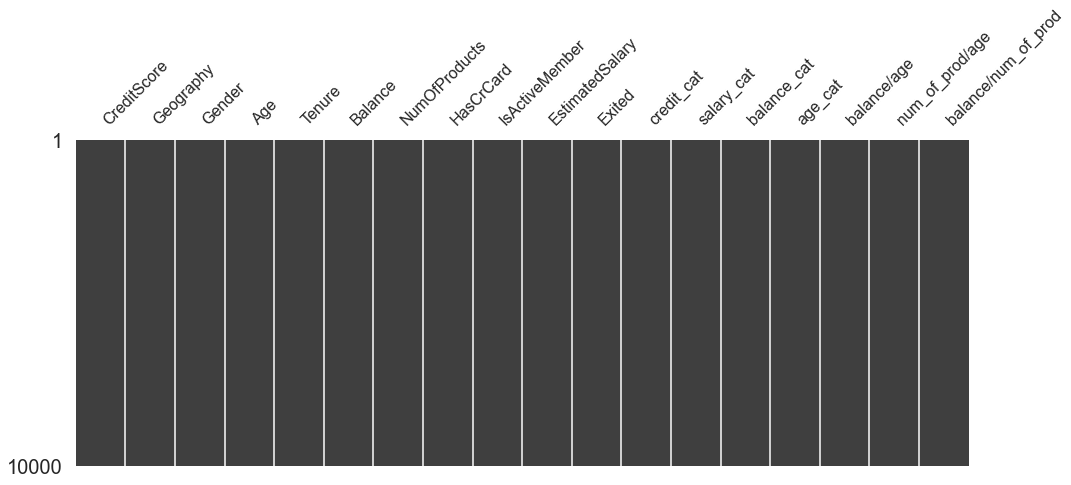

In [357]:
#Check for missing values
fig, ax = plt.subplots(figsize=(16,6))

mnso.matrix(df, ax=ax) ;

## 1.5 Sanity check  

It is **possible that the numerical data has some 'weird' values far out what is expected**. For example, the *'Age'* column having some clients with 120 years. **This statistical analysis** goal is to get a **feeling about the data** and make a **sanity check** 

**Conclusion**: **the data doesn't seem to have an oddly number of outliers**. Statistics such as distribution, mean and median doesn't seems to be out of expected

In [9]:
#Transforming categorical 1 or 0 variables into 'yes' and 'no' 

col_str = ['HasCrCard', 'IsActiveMember', 'Exited']

for col in col_str:
    df[col] = df[col].astype('str') 

for col in col_str:
    df[col] = df[col].apply(lambda x: 'yes' if x=='1' else 'no')

In [10]:
#Isolate numerical and categorical variables

numerical = df.select_dtypes(include=['int64', 'float64'])
categorical = df.select_dtypes(exclude=['int64', 'float64'])

In [11]:
#Numerical variables - Statistics - std, min, max, range, skew, kurtosis

ct1 = pd.DataFrame(numerical.apply(np.mean)).round(2).T
ct2 = pd.DataFrame(numerical.apply(np.median)).round(2).T

d1 = pd.DataFrame(numerical.apply(np.std)).round(2).T
d2 = pd.DataFrame(numerical.apply(min)).T
d3 = pd.DataFrame(numerical.apply(max)).T
d4 = pd.DataFrame(numerical.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(numerical.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(numerical.apply(lambda x: x.kurtosis())).T

a = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
a.columns = ['columns', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
a

columns     min        max      range       mean     median       std      skew  kurtosis
0      CreditScore  350.00     850.00     500.00     650.53     652.00     96.65 -0.071607 -0.425726
1              Age   18.00      92.00      74.00      38.92      37.00     10.49  1.011320  1.395347
2           Tenure    0.00      10.00      10.00       5.01       5.00      2.89  0.010991 -1.165225
3          Balance    0.00  250898.09  250898.09   76485.89   97198.54  62394.29 -0.141109 -1.489412
4    NumOfProducts    1.00       4.00       3.00       1.53       1.00      0.58  0.745568  0.582981
5  EstimatedSalary   11.58  199992.48  199980.90  100090.24  100193.92  57507.62  0.002085 -1.181518

## 1.6 Zero values distribution

**Sometimes the data isn't missing (NaNs), but it can be in a form of an oddly high number of zero values** 

**Conclusion**: The ***'Balance'* columns have a great number of zeros**, but it doesn't mean they are missing values (NaNs). Nevertheless, the Data Science team should get in contact with the business team to check if this number is correct 

In [12]:
#Create DataFrame with zero and non zero values

num_zero = numerical.copy()
num_col = num_zero.columns

for col in num_col :
    num_zero[col] = num_zero[col].apply(lambda x: 'zero' if x==0 else 'not zero')

In [13]:
#See which columns have zero values 

num_zero.apply( lambda x: x.unique().shape[0])

CreditScore        1
Age                1
Tenure             2
Balance            2
NumOfProducts      1
EstimatedSalary    1
dtype: int64

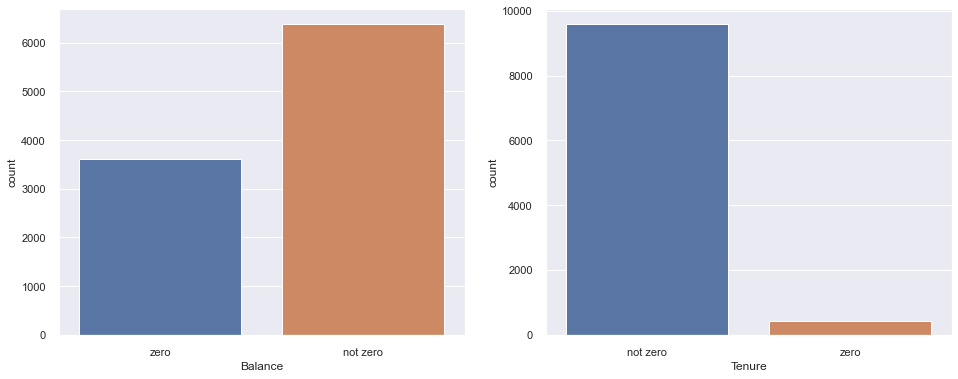

In [14]:
#Plot zero values proportion 

plt.rcParams['figure.figsize'] = [16, 6]
plt.subplot(1,2,1)
sns.countplot(x='Balance', data=num_zero) 

plt.subplot(1,2,2)
sns.countplot(x='Tenure', data=num_zero) ;

# 2.0 Exploratory Data Analysis

The goal is to **explore** and **understand the dataset**. The strategy is first make a **quick descriptive analysis** and then go deeper in a **hyphotesis driven analysis**

## 2.1 Univariate descriptive analysis

### 2.1.1 Target variable

The **target data is unbalanced**: **churn clients** are **20%**; **not churn** are **80%**

In [15]:
#Percentual proportion of the target variable

df['Exited'].value_counts(normalize=True)*100

no     79.63
yes    20.37
Name: Exited, dtype: float64

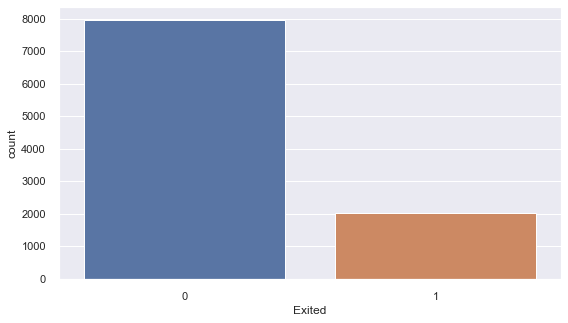

In [292]:
#See the visual distribution of the target variable

plt.rcParams['figure.figsize'] = [9, 5]

sns.countplot(x='Exited', data=df) ;

### 2.1.2 Numerical variables

Look at the **overall outlook of the numerical features** to get a general idea of their distribution

**Conclusion**: the only feature that looks like a normal distribution is *'CreditScore'*; all the other features are skewed

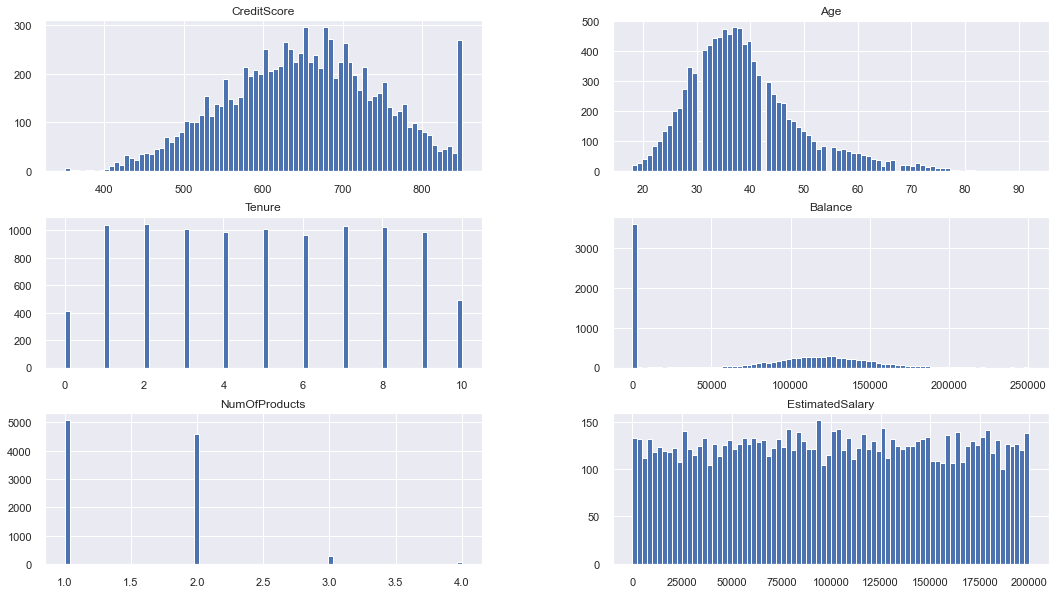

In [17]:
#See the overview of the distribution
plt.rcParams['figure.figsize'] = [18, 10]

numerical.hist(bins=80) ;

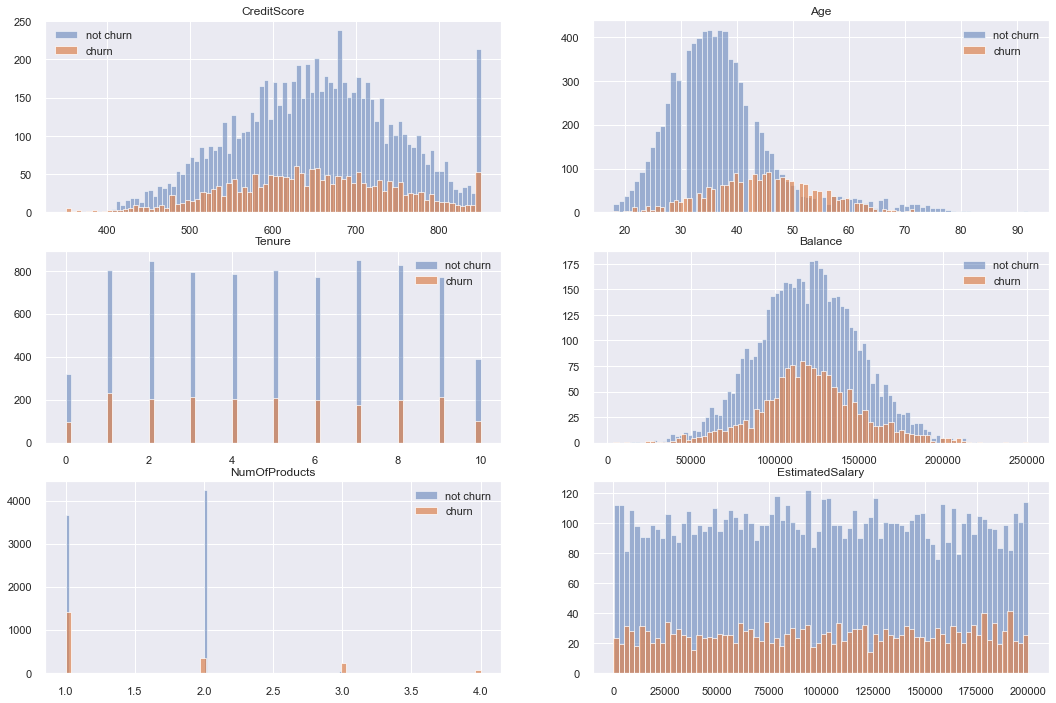

In [18]:
#Plot histogram with target variable

exited_num = df[['Exited','CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
num_churn = exited_num[exited_num['Exited'] == 'yes']
num_n_churn = exited_num[exited_num['Exited'] == 'no']

fig, ax = plt.subplots(3,2, figsize=(18,12))

ax[0,0].hist(num_n_churn['CreditScore'], bins=80, alpha = 0.5, label='not churn') 
ax[0,0].hist(num_churn['CreditScore'], bins=80, alpha = 0.7, label='churn') 
ax[0,0].legend() 
ax[0,0].set_title('CreditScore')

ax[0,1].hist(num_n_churn['Age'], bins=80, alpha = 0.5, label='not churn') 
ax[0,1].hist(num_churn['Age'], bins=80, alpha = 0.7, label='churn') 
ax[0,1].legend() 
ax[0,1].set_title('Age')

ax[1,0].hist(num_n_churn['Tenure'], bins=80, alpha = 0.5, label='not churn') 
ax[1,0].hist(num_churn['Tenure'], bins=80, alpha = 0.7, label='churn')
ax[1,0].legend() 
ax[1,0].set_title('Tenure')

num_n_churn_z = num_n_churn[num_n_churn['Balance'] != 0] #only the non zero values
num_churn_z = num_churn[num_churn['Balance'] != 0]
ax[1,1].hist(num_n_churn_z['Balance'], bins=80, alpha = 0.5, label='not churn') 
ax[1,1].hist(num_churn_z['Balance'], bins=80, alpha = 0.7, label='churn') 
ax[1,1].legend() 
ax[1,1].set_title('Balance')

ax[2,0].hist(num_n_churn['NumOfProducts'], bins=80, alpha = 0.5, label='not churn') 
ax[2,0].hist(num_churn['NumOfProducts'], bins=80, alpha = 0.7, label='churn')
ax[2,0].legend() 
ax[2,0].set_title('NumOfProducts')

ax[2,1].hist(num_n_churn['EstimatedSalary'], bins=80, alpha = 0.5, label='not churn') 
ax[2,1].hist(num_churn['EstimatedSalary'], bins=80, alpha = 0.7, label='churn')
ax[2,1].set_title('EstimatedSalary');

In [19]:
#Rescale the numerical variables to plot
mms = MinMaxScaler()

exited_num['CreditScore'] = mms.fit_transform(exited_num[['CreditScore']].values)

exited_num['Age'] = mms.fit_transform(exited_num[['Age']].values)

exited_num['Tenure'] = mms.fit_transform(exited_num[['Tenure']].values)

exited_num['Balance'] = mms.fit_transform(exited_num[['Balance']].values)

exited_num['NumOfProducts'] = mms.fit_transform(exited_num[['NumOfProducts']].values)

exited_num['EstimatedSalary'] = mms.fit_transform(exited_num[['EstimatedSalary']].values)

In [20]:
#Separate X and y

X = exited_num.drop('Exited', axis=1).copy()

y = exited_num['Exited']

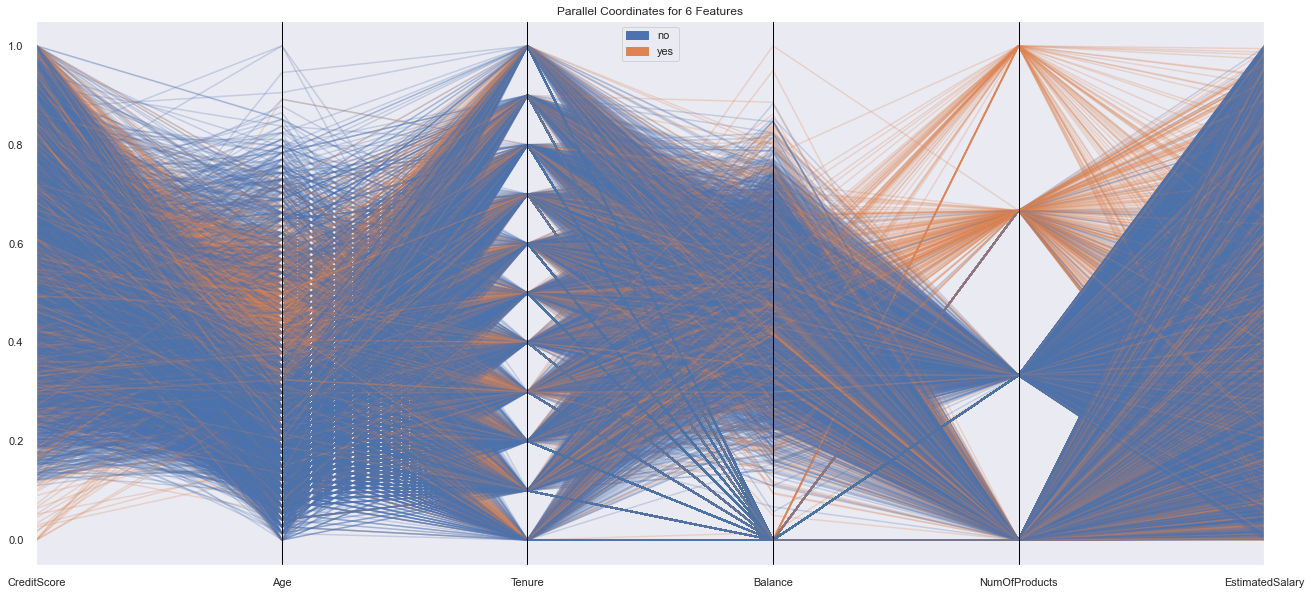

In [21]:
#Fix to only numerical features 
mpl.rcParams["figure.figsize"] = (22,10)

visualizer = ParallelCoordinates()
visualizer.fit(X, y)           
visualizer.transform(X)       
visualizer.show() ;               

### 2.1.3 Categorical variable

**First overview of the each classes** of categorical data

In [22]:
#Check for unique categories 

categorical.apply( lambda x: x.unique().shape[0])

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
Exited            2
dtype: int64

In [23]:
#Geography

df_cat('Geography') #see more about df_cat() in the helper functions section

absolute  percentage
Geography                      
France         5014       50.14
Germany        2509       25.09
Spain          2477       24.77

In [24]:
#Gender

df_cat('Gender')

absolute  percentage
Gender                      
Male        5457       54.57
Female      4543       45.43

In [25]:
#HasCrCard

df_cat('HasCrCard')

absolute  percentage
HasCrCard                      
yes            7055       70.55
no             2945       29.45

In [26]:
#IsActiveMember

df_cat('IsActiveMember')

absolute  percentage
IsActiveMember                      
yes                 5151       51.51
no                  4849       48.49

In [27]:
#Exited

df_cat('Exited')

absolute  percentage
Exited                      
no          7963       79.63
yes         2037       20.37

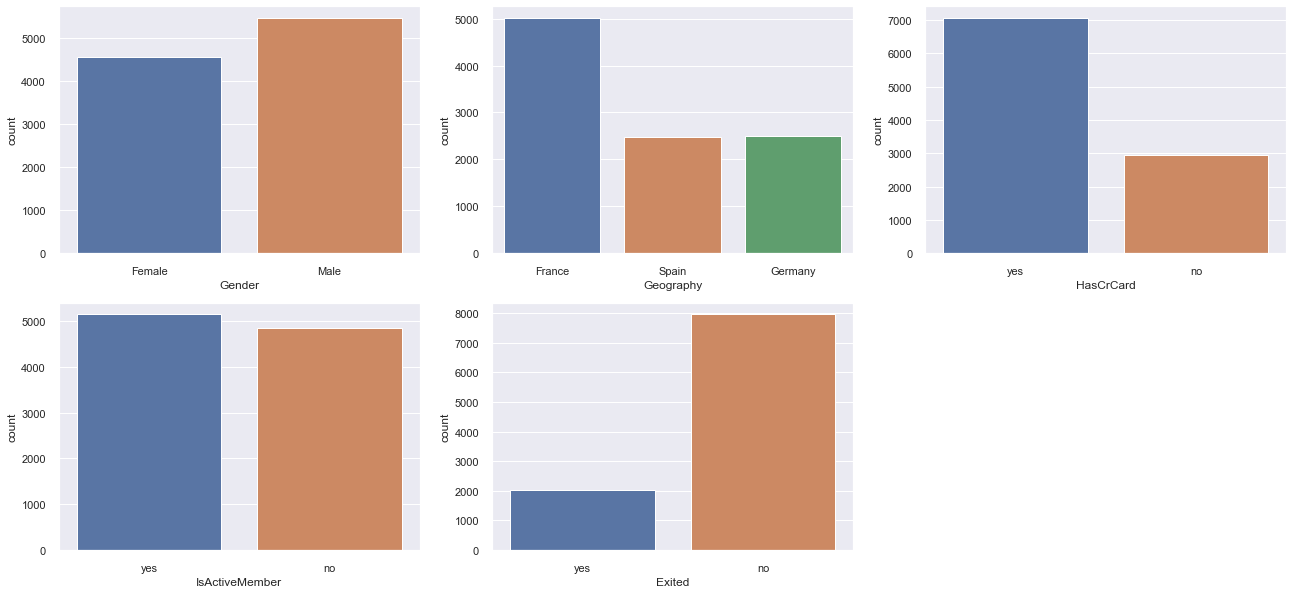

In [28]:
#See the distribution of categorical variables

plt.subplot(2,3,1)
sns.countplot(x='Gender', data=categorical)

plt.subplot(2,3,2)
sns.countplot(x='Geography', data=categorical)

plt.subplot(2,3,3)
sns.countplot(x='HasCrCard', data=categorical)

plt.subplot(2,3,4)
sns.countplot(x='IsActiveMember', data=categorical)

plt.subplot(2,3,5)
sns.countplot(x='Exited', data=categorical) ;

## 2.2 Multivariate descriptive analysis

### 2.3.1 Numerical variables

#### 3.3.1.1 Correlation 

Before applying any Machine Learning model, it is **important to see the correlation** between **features** and the **target variable** (*'Exited'*). The goal is to have an idea of **which variables**, in isolation, will be potentially **more relevant to the algorithm prediction**

**Conclusion**: 03 variables have shown some correlation with churn clients: ***'Age'***, ***'Balance'*** and ***'NumOfProducts'***

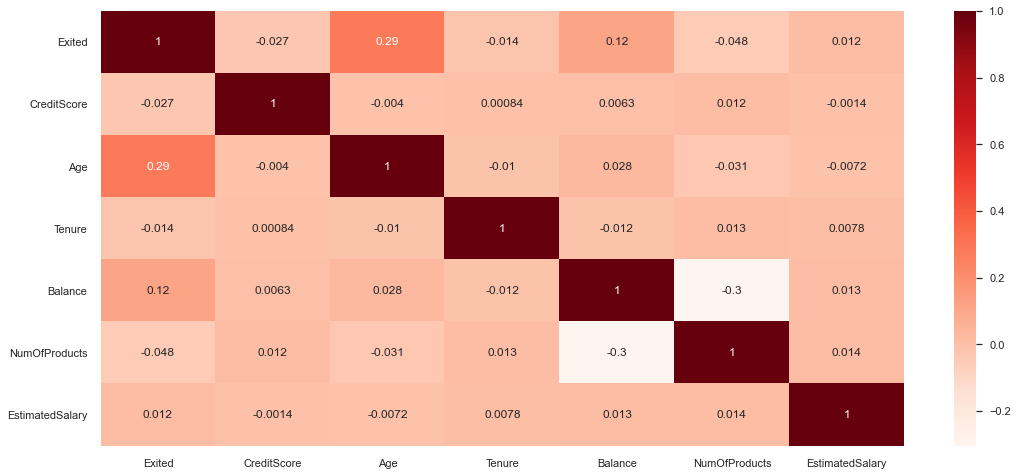

In [29]:
#Correlation of numerical variables

df['Exited'] = df['Exited'].map({'yes':1,'no':0})
df['Exited'] = df['Exited'].astype('int')
df_corr = df[['Exited','CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]

plt.rcParams['figure.figsize'] = [18, 8] #See if there is figuresize argument
correlation = df_corr.corr(method='pearson')
sns.heatmap(correlation, annot=True, cmap='Reds');

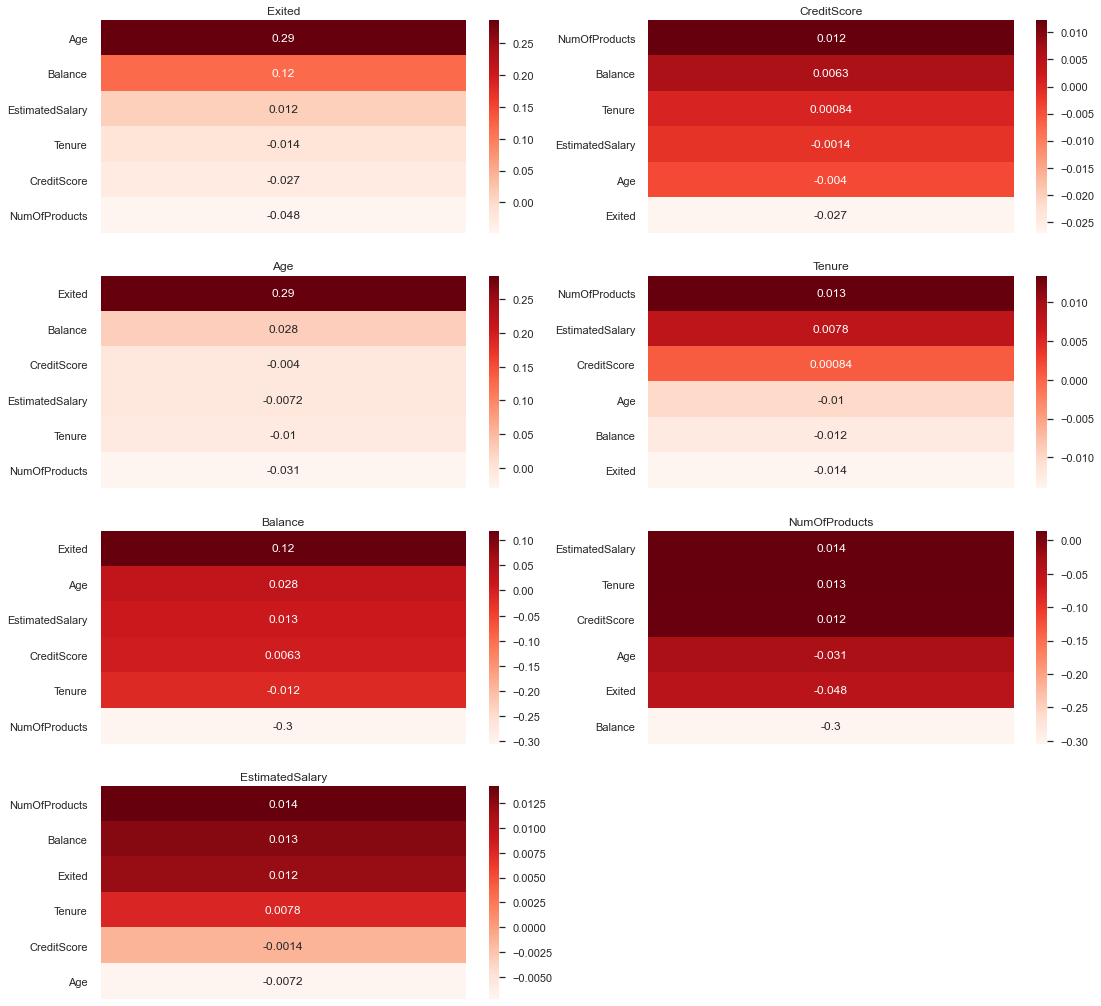

In [30]:
#Ranking of correlation between each variable 

plt.subplots(figsize=(18,18))
plt.subplot(4,2,1)
plot_corr('Exited')

plt.subplot(4,2,2)
plot_corr('CreditScore') 

plt.subplot(4,2,3)
plot_corr('Age') 

plt.subplot(4,2,4)
plot_corr('Tenure') 

plt.subplot(4,2,5)
plot_corr('Balance') 

plt.subplot(4,2,6)
plot_corr('NumOfProducts') 

plt.subplot(4,2,7)
plot_corr('EstimatedSalary') ;

#### 3.3.1.2 Multivariate descriptive analysis 

The features ***'Age'***, ***'Balance'*** and ***'NumOfProducts'***, according to the previous correlation analysis, are more relevant to predict the target variable *'Exited'* clients. For this reason, **these are the variables chosen to the multivariate descriptive analysis**
**Conclusions**:
- ***Age***: it has great impact since **older clients have more tendency to be churn**
- ***NumOfProducts***: the general outlook is that there is more number of absolute churn clients with just 1 product, which seems to decrease with 2 products; however, the few clients with 3 and 4 products are mainly churns

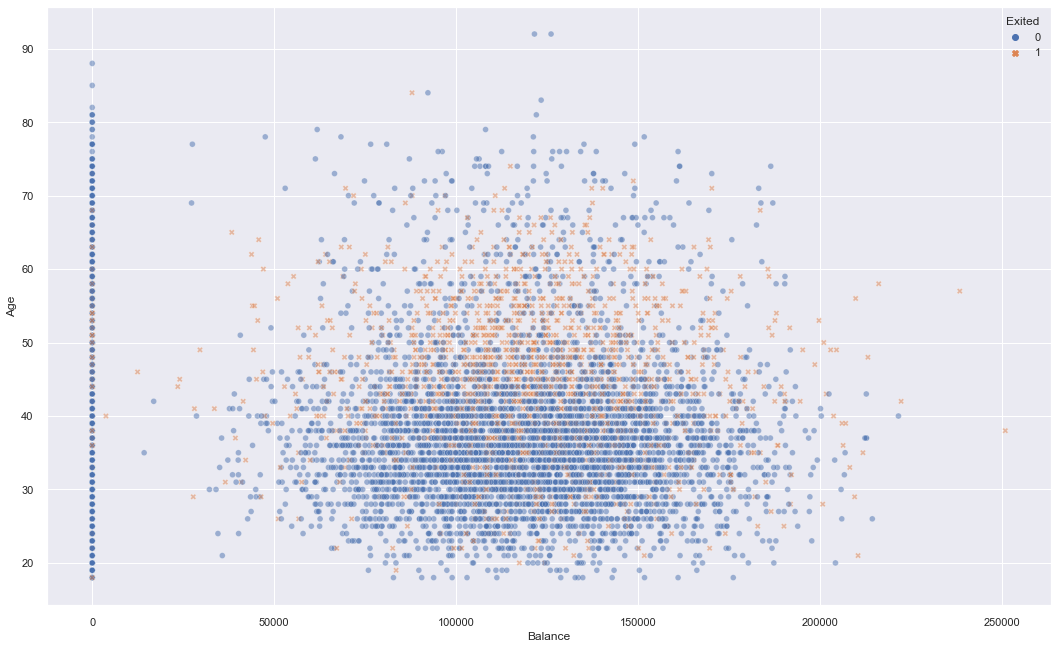

In [31]:
#Plot multivariate plot - Balance x Age x Exited (target)

plt.rcParams['figure.figsize'] = [18, 11] #See if there is figuresize argument

sns.scatterplot(x='Balance', y='Age', data=df, hue='Exited', hue_order=[0,1], alpha=0.5, style='Exited', style_order=[0,1],cmap='GnBu') ;


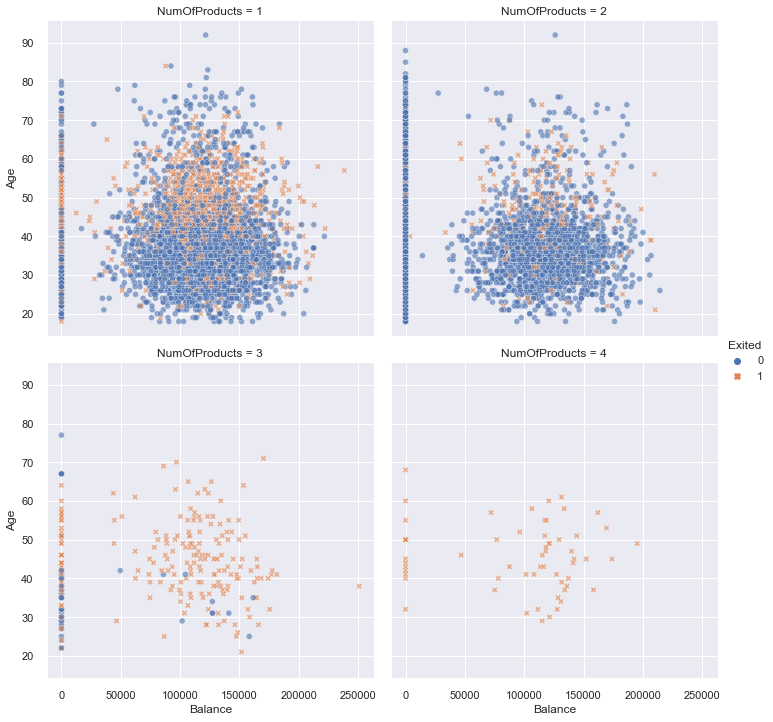

In [32]:
#Plot multivariate plot -  NumOfProducts x Balance x Age x Exited

plt.rcParams['figure.figsize'] = [18, 11] #See if there is figuresize argument

sns.relplot(x='Balance', y='Age', data=df, hue='Exited', hue_order=[0,1], alpha=0.6, style='Exited', col='NumOfProducts', col_wrap=2) ;


### 2.3.2 Categorical variables

#### 3.3.2.1 Correlation

Here, the correlation between the categorical variables is calculated with the **Cramer's V method**

**Conclusion**: 03 categorial variables have shown some correlation with churn clients: ***'Geography'***, ***'IsActiveMember'*** and ***'Gender'***

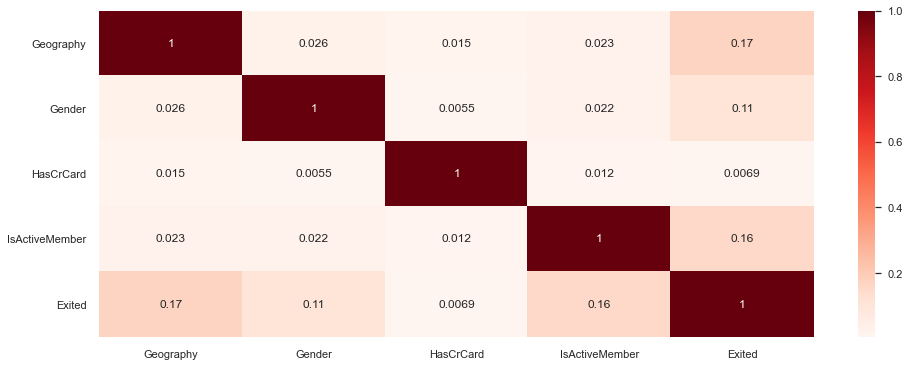

In [360]:
#Select categorical data
df['Exited'] = df['Exited'].astype('str')

a = df.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v( a['Geography'], a['Geography'] )
a2 = cramer_v( a['Geography'], a['Gender'] )
a3 = cramer_v( a['Geography'], a['HasCrCard'] )
a4 = cramer_v( a['Geography'], a['IsActiveMember'] )
a5 = cramer_v( a['Geography'], a['Exited'] )

a6 = cramer_v( a['Gender'], a['Geography'] )
a7 = cramer_v( a['Gender'], a['Gender'] )
a8 = cramer_v( a['Gender'], a['HasCrCard'] )
a9 = cramer_v( a['Gender'], a['IsActiveMember'] )
a10 = cramer_v( a['Gender'], a['Exited'] )

a11 = cramer_v( a['HasCrCard'], a['Geography'] )
a12 = cramer_v( a['HasCrCard'], a['Gender'] )
a13 = cramer_v( a['HasCrCard'], a['HasCrCard'] )
a14 = cramer_v( a['HasCrCard'], a['IsActiveMember'] )
a15 = cramer_v( a['HasCrCard'], a['Exited'] )

a16 = cramer_v( a['IsActiveMember'], a['Geography'] )
a17 = cramer_v( a['IsActiveMember'], a['Gender'] )
a18 = cramer_v( a['IsActiveMember'], a['HasCrCard'] )
a19 = cramer_v( a['IsActiveMember'], a['IsActiveMember'] )
a20 = cramer_v( a['IsActiveMember'], a['Exited'] )

a21 = cramer_v( a['Exited'], a['Geography'] )
a22 = cramer_v( a['Exited'], a['Gender'] )
a23 = cramer_v( a['Exited'], a['HasCrCard'] )
a24 = cramer_v( a['Exited'], a['IsActiveMember'] )
a25 = cramer_v( a['Exited'], a['Exited'] )

# Final dataset
d = pd.DataFrame( {'Geography': [a1, a2, a3, a4, a5], 'Gender': [a6, a7, a8, a9, a10], 'HasCrCard': [a11, a12, a13, a14, a15], 'IsActiveMember':[a16, a17, a18, a19, a20], 'Exited':[a21, a22, a23, a24, a25]})                                                                         
d = d.set_index( d.columns )

plt.rcParams['figure.figsize'] = [16, 6] #See if there is figuresize argument
sns.heatmap( d, annot=True, cmap='Reds') ;

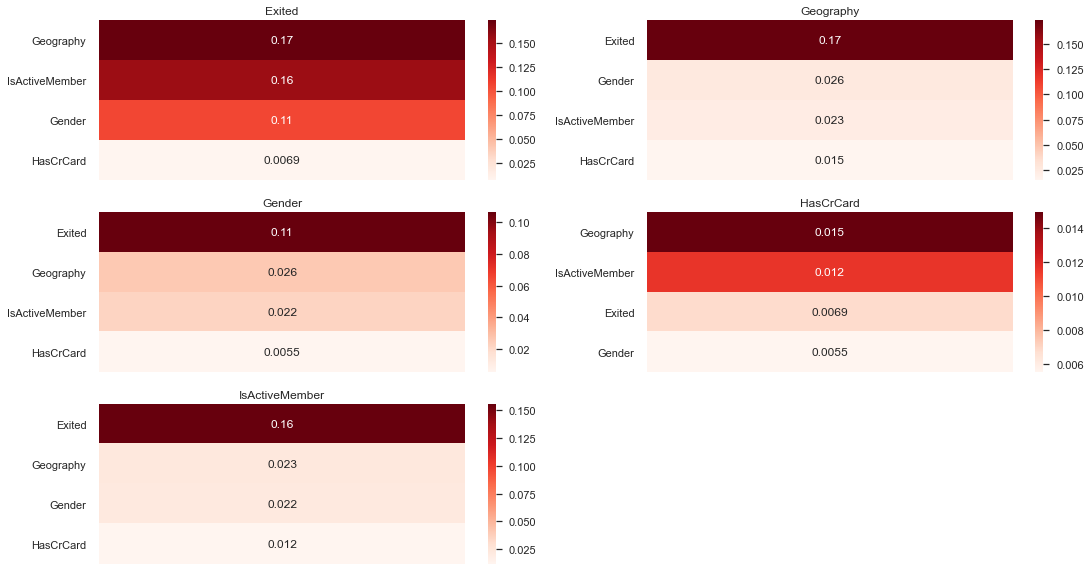

In [34]:
#Ranking of correlation between variables 

plt.subplots(figsize=(18,10))
plt.subplot(3,2,1)

plot_corr_cat('Exited')

plt.subplot(3,2,2)
plot_corr_cat('Geography') 

plt.subplot(3,2,3)
plot_corr_cat('Gender') 

plt.subplot(3,2,4)
plot_corr_cat('HasCrCard') 

plt.subplot(3,2,5)
plot_corr_cat('IsActiveMember') ;

#### 3.3.2.1 Categories/target descriptive analysis 

Since there is only 4 categorical features and 3 features with relevant correlation, it is worth seeing how all of them respond to the target variable, **conclusion**:  
- ***'Geography'***: clients have significantly more chance to be a churn in ***Germany***  than in other countries. Their ***churn rate is ~12% higher (32%)*** and ***correspond to 40% of total churns***, percentage equal to France even though France has an higher number of absolute clients
- ***'IsActiveMember'***: active members have globaly ***6% less of churn clients (14%)***; active clients ***correspond only to 36% of churn clients*** even though ***they are 52% o total clients***
- ***'Gender'***: women have globaly ***5% more of churn clients (25%)***; women also ***correspond to 56% of churn clients*** even though ***they are 45% o total clients***
- As expected with the correlation analysis, the ***HasCrCard*** feature is doesn't vary between churn and not churn clients

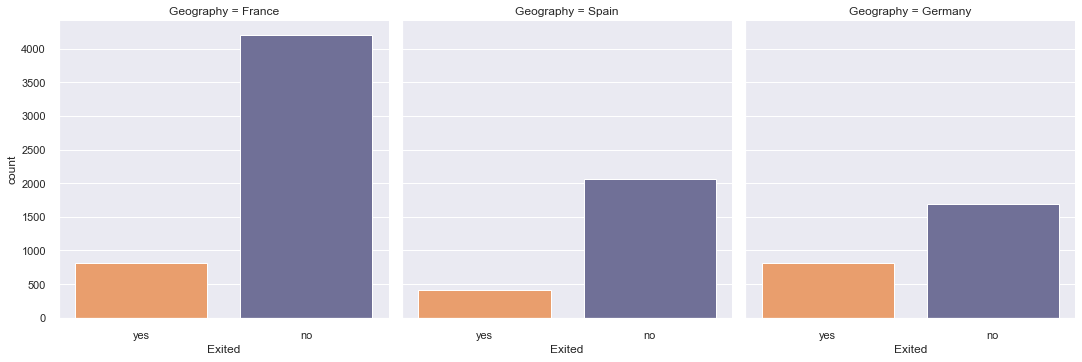

In [35]:
#Geography - countplot by class

colors = ['#fe9a58', '#6a699e']
sns.set_palette(sns.color_palette(colors))

sns.catplot(x='Exited', data=categorical, kind='count', col='Geography', hue_order=['no','yes'], legend=True) ;

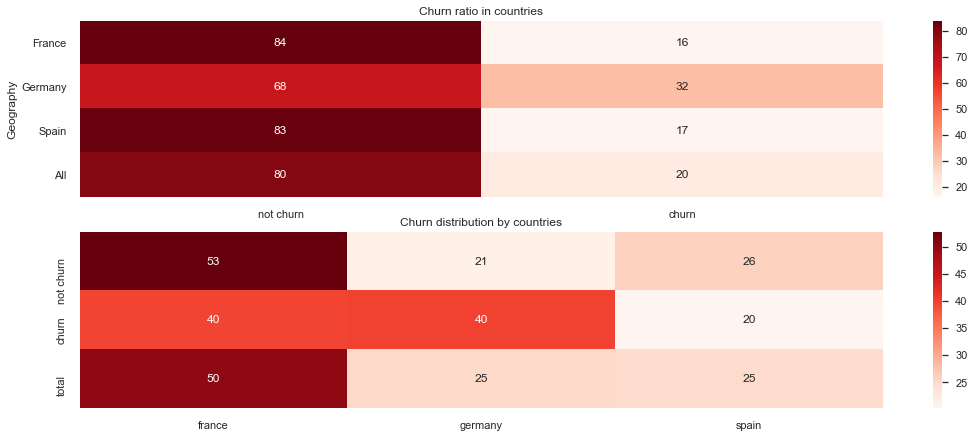

In [36]:
#Geography - percentage ratio distribution

plt.subplots(figsize=(18,11))
plt.subplot(3,1,1)
a = categorical.pivot_table(values='Gender', index='Geography', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)

a.drop('total', axis=1, inplace=True)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn ratio in countries') ;

plt.subplot(3,1,2)
a = categorical.pivot_table(values='Gender', index='Exited', columns='Geography', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T
a.columns = ['france', 'germany', 'spain', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
a.drop('total', axis=1, inplace=True)

sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn distribution by countries') ;

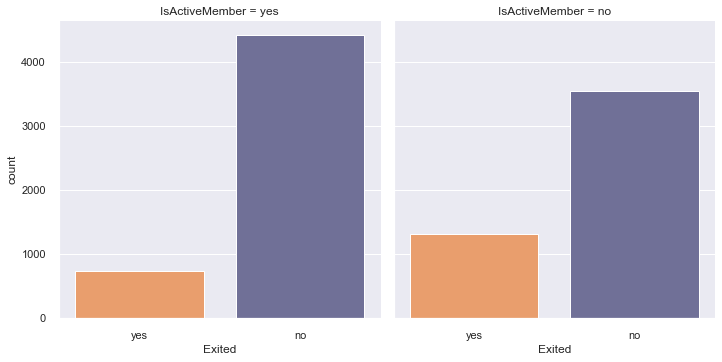

In [37]:
#Active members - countplot by class

sns.catplot(x='Exited', data=categorical, kind='count', col='IsActiveMember', hue_order=['no','yes'], legend=True) ;

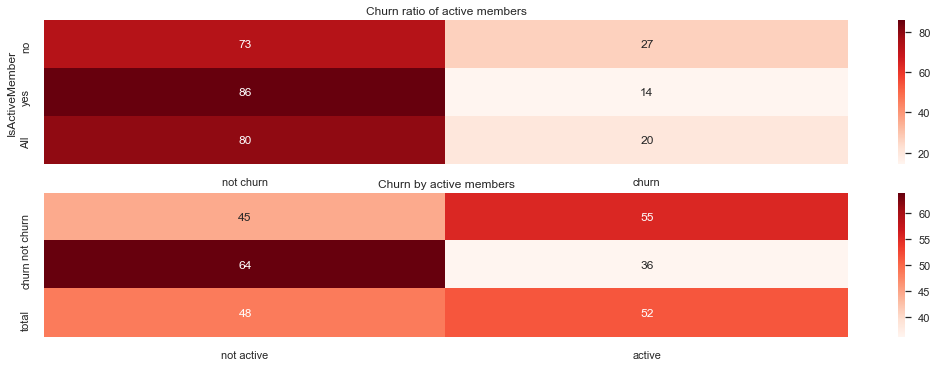

In [38]:
#Active members - percentage ratio distribution

plt.subplots(figsize=(18,9))
plt.subplot(3,1,1)
a = categorical.pivot_table(values='Gender', index='IsActiveMember', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)

a.drop('total', axis=1, inplace=True)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn ratio of active members')

plt.subplot(3,1,2)
a = categorical.pivot_table(values='Gender', index='Exited', columns='IsActiveMember', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T

a.columns = ['not active', 'active', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)

a.drop('total', axis=1, inplace=True)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by active members') ; 

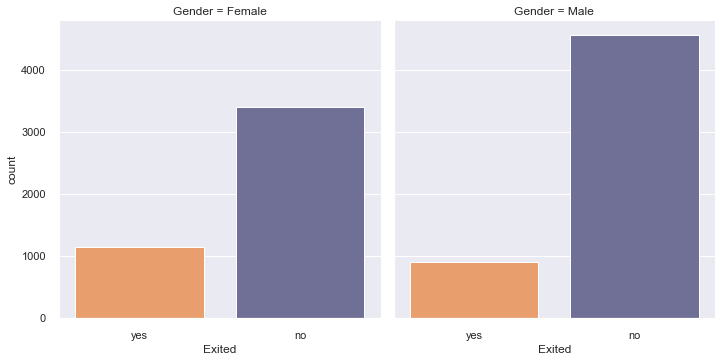

In [39]:
#Gender - countplot by class

sns.catplot(x='Exited', data=categorical, kind='count', col='Gender', hue_order=['no','yes'], legend=True) ;

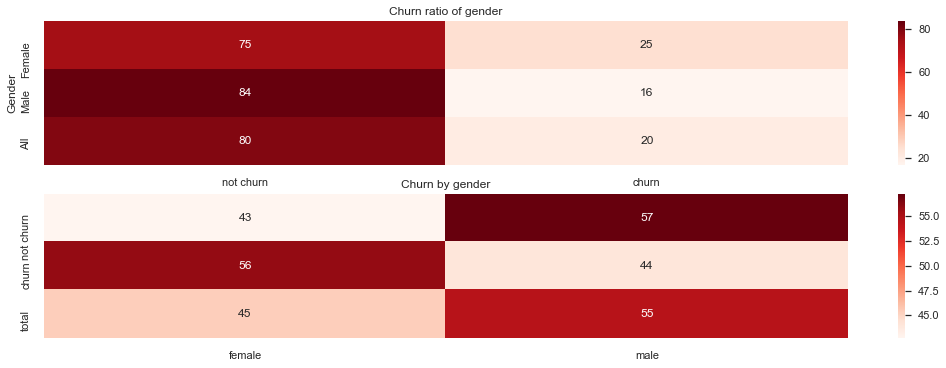

In [40]:
#Gender - percentage ratio distribution

plt.subplots(figsize=(18,9))
plt.subplot(3,1,1)
a = categorical.pivot_table(values='Geography', index='Gender', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)

a.drop('total', axis=1, inplace=True)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn ratio of gender')

plt.subplot(3,1,2)
a = categorical.pivot_table(values='Geography', index='Exited', columns='Gender', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T
a.columns = ['female', 'male', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
    
a.drop('total', axis=1, inplace=True)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by gender') ;

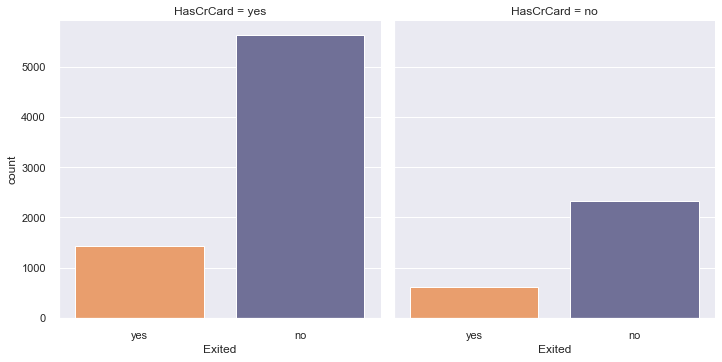

In [41]:
#HasCrCard - countplot by class

sns.catplot(x='Exited', data=categorical, kind='count', col='HasCrCard', hue_order=['no','yes'], legend=True) ;

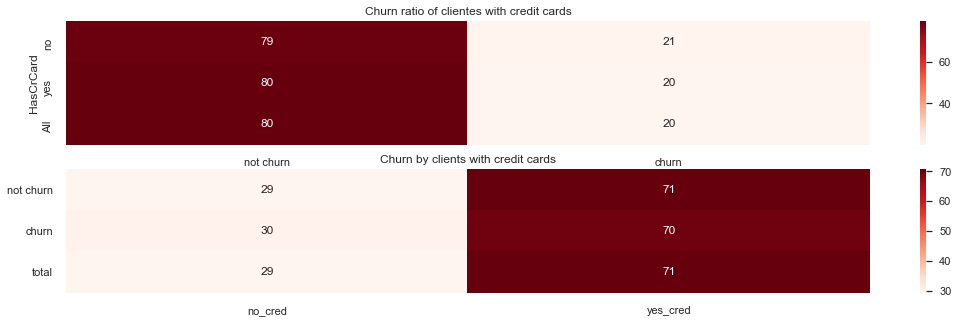

In [361]:
#HasCrCard - percentage ratio distribution

plt.subplots(figsize=(18,5))
plt.subplot(2,1,1)
a = categorical.pivot_table(values='Gender', index='HasCrCard', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)

a.drop('total', axis=1, inplace=True)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn ratio of clientes with credit cards') 

plt.subplot(2,1,2)
a = categorical.pivot_table(values='Gender', index='Exited', columns='HasCrCard', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T
a.columns = ['no_cred', 'yes_cred', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
    
a.drop('total', axis=1, inplace=True)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by clients with credit cards') ;

## 2.3 Hyphotesis driven analysis

The **goal** of the **hyphotesis driven analysis** is **to answer questions that are not clear after the brief overall descriptive analysis**. Especially the **numercial variables** that where not analyzed in depth, in oppose to the categorical variables

### 2.3.1 Features mindmap 

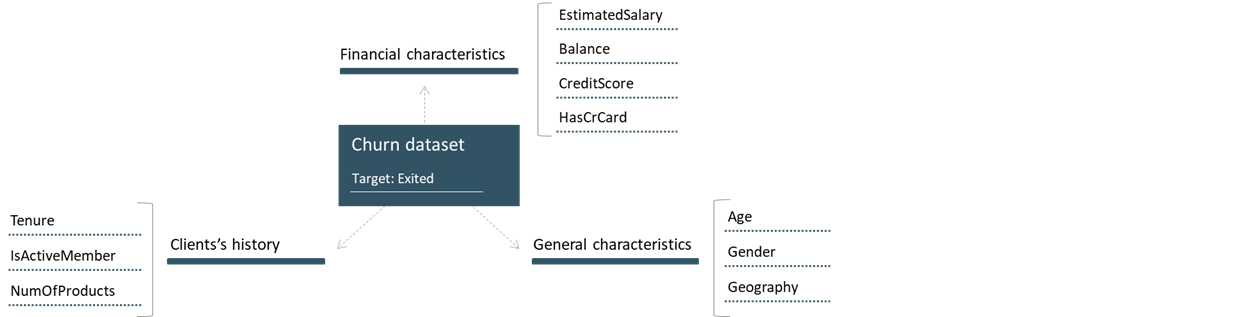

### 2.3.2 Hypothesis creation

#### 2.3.2.1 Financial characteristics

**1.** Clients that have a bad **Credit Score** do tend to be a churn (*CreditScore*)

**2.** Clients with a greater anual **Estimated Salary** do tend to be churns (*EstimatedSalary*)

**3.** Clients that **have more money in their balance** do tend to be churn (*Balance*)

#### 2.3.2.1 Client history

**4.** Clients with greater **tenure** do not tend to be a churn (*Tenure*)

**5.** Clients that have a greater **number of products** do not tend to be a churn (*NumOfProducts*)

#### 2.3.2.1 General characteristics

**6.** **Older people** tend to be a churn (*Age*)

### 2.3.3 Hypothesis testing

#### **H1.** Clients that have a bad **Credit Score** do tend to be a churn (*CreditScore*)
**FALSE**: there is not significant difference in churn of clients with high or low credit score

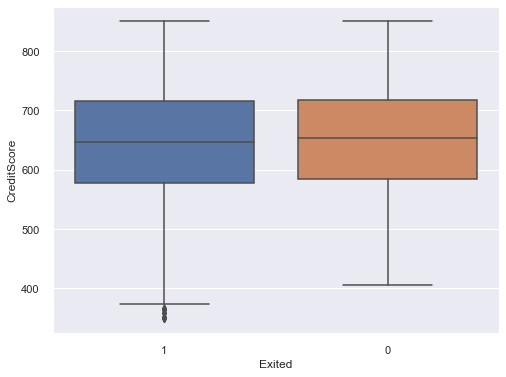

In [362]:
#Boxplot CreditScore of churn clients

plt.rcParams['figure.figsize'] = [8, 6]
sns.boxplot(x='Exited', y='CreditScore', data=df) ;

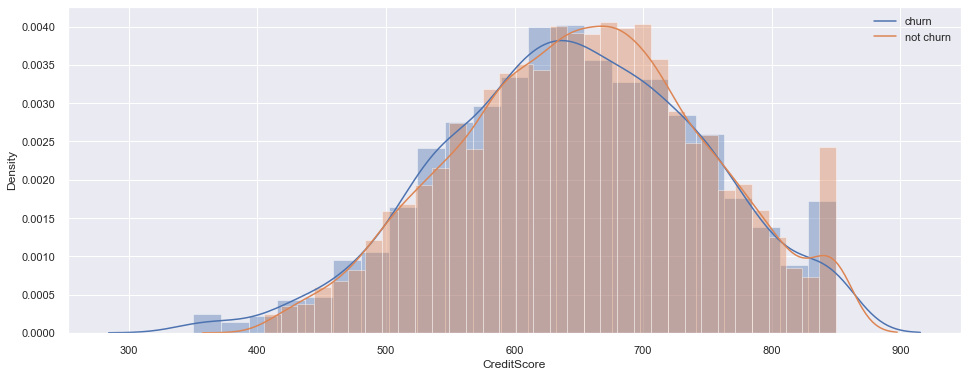

In [364]:
#Density plot of Credit Scores of churn clients

plt.rcParams['figure.figsize'] = [16, 6]

sns.distplot(df[df['Exited'] == '1']['CreditScore'], label='churn')
sns.distplot(df[df['Exited'] == '0']['CreditScore'], label='not churn')

plt.legend(['churn', 'not churn']) ;

In [45]:
#Credit Score stats

score = df.groupby(['Exited'])['CreditScore'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
score = score.T
score.columns = ['not churn', 'churn']
score = score.T

score

count        mean  median         std    min    max
not churn  7963.0  651.853196   653.0   95.653837  405.0  850.0
churn      2037.0  645.351497   646.0  100.321503  350.0  850.0

In [46]:
#Create salaries categories
bins = list(np.arange(300,900,25))

df['credit_cat'] = pd.cut(df['CreditScore'], bins=bins)

#Clean characters
df['credit_cat'] = df['credit_cat'].astype('str')
df['credit_cat'] = df['credit_cat'].str.replace('(','')
df['credit_cat'] = df['credit_cat'].str.replace(']','')
df['credit_cat'] = df['credit_cat'].str.split(',', expand=True)[1]
df['credit_cat'] = df['credit_cat'].astype('int')

In [47]:
#CreditScore categories stats

a = df.groupby(['credit_cat'])['CreditScore'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a

count        mean  median       std  min  max
credit_cat                                               
350             5  350.000000     350  0.000000  350  350
375             7  362.285714     363  7.087884  351  373
400             7  385.285714     383  8.864053  376  399
425            51  415.725490     416  6.026868  401  425
450           119  438.243697     438  7.159167  426  450
475           168  463.880952     465  7.266369  451  475
500           286  488.814685     489  7.264231  476  500
525           427  513.592506     514  7.215511  501  525
550           551  538.419238     539  7.357143  526  550
575           621  562.938808     563  7.214420  551  575
600           824  588.229369     588  7.127348  576  600
625           892  612.997758     613  7.290200  601  625
650           979  638.055158     638  7.144651  626  650
675           969  662.552116     663  7.210359  651  675
700           978  687.376278     687  7.253808  676  700
725           846  712.229314     712  7.031082  701  725
750           672  737.611607     738  7.384443  726  750
775           557  762.470377     762  7.519132  751  775
800           396  787.297980     787  7.148486  776  800
825           249  811.473896     811  6.866257  801  825
850           396  844.694444     850  7.689221  826  850

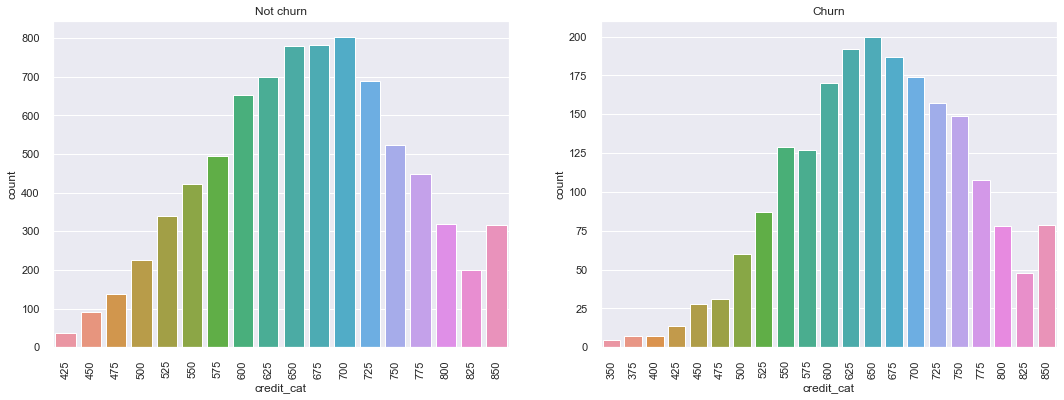

In [365]:
#Plot salary categories
plt.rcParams['figure.figsize'] = [18, 6]

df.sort_values(by='credit_cat', inplace=True)
not_churn = df[df['Exited'] == '0']
churn = df[df['Exited'] == '1']

plt.subplot(1,2,1)
sns.countplot(x='credit_cat', data=not_churn).set_title('Not churn')
plt.xticks(rotation=90) 

plt.subplot(1,2,2)
sns.countplot(x='credit_cat', data=churn).set_title('Churn')
plt.xticks(rotation=90) ;

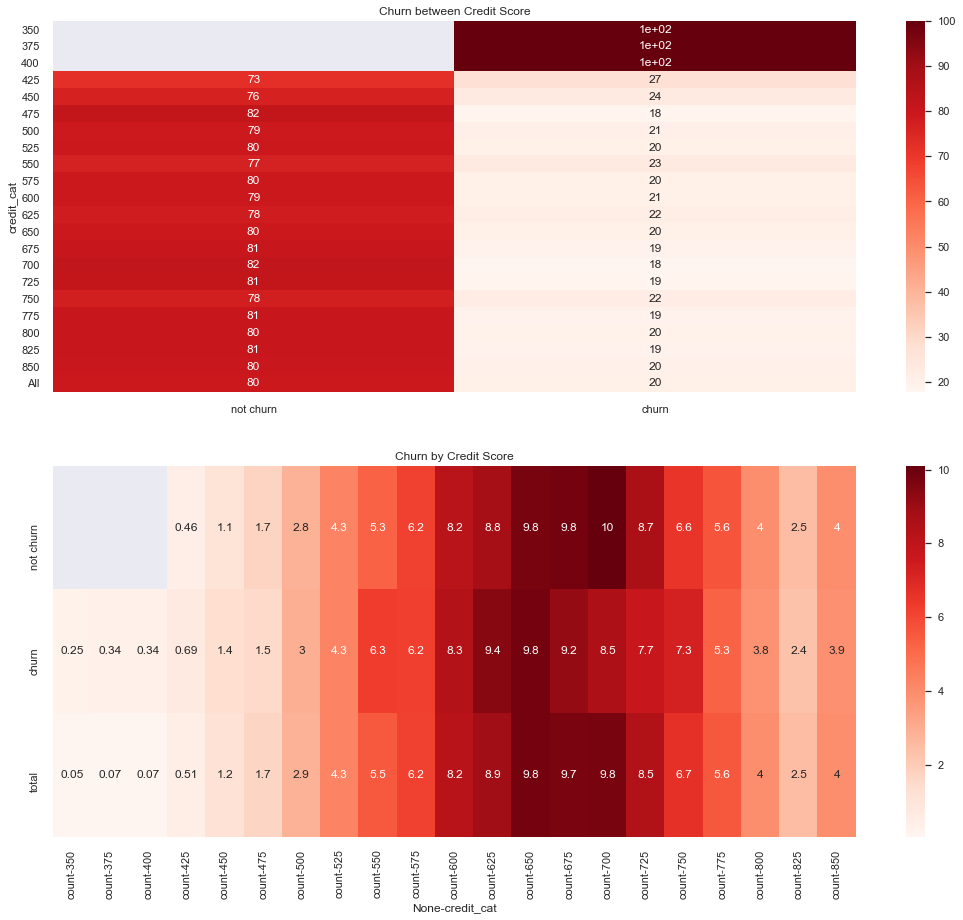

In [49]:
#CreditScore - Percentage ratio heatmap
plt.subplots(figsize=(18,15))

a = df.pivot_table(values='Gender', index='credit_cat', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
a.drop('total', axis=1, inplace=True)

plt.subplot(2,1,1)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn between Credit Score') 

a = df.pivot_table(values='Gender', index='Exited', columns='credit_cat', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T

for col in a.columns:
    a[col] = (a[col]/a[('count', 'All')]*100).round(2)    
a.drop([('count', 'All')], axis=1, inplace=True)

plt.subplot(2,1,2)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by Credit Score') ;

#### **H2.** Clients with a greater anual **Estimated Salary** do tend to be churns (*EstimatedSalary*)

**TRUE**: clients with a **greater anual Estimate Salary have slightly more chance to be a churn**; in the salary category of salaries of 140.000 dollars to 150.000 dollars up to 200.000 dollars **all have 1% more chance to be a churn (21%)**

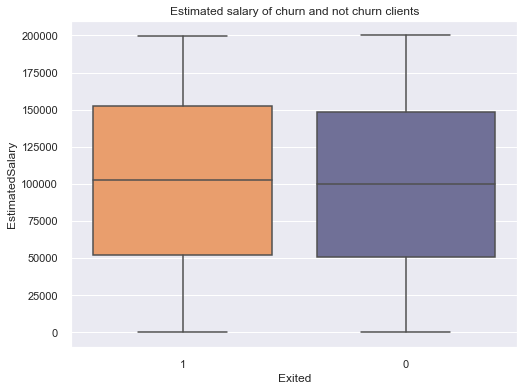

In [366]:
#Summary boxplot of Estimated Salary of exit clients
plt.rcParams['figure.figsize'] = [8, 6]
colors = ['#fe9a58', '#6a699e']
sns.set_palette(sns.color_palette(colors))

sns.boxplot(x='Exited', y='EstimatedSalary', data=df).set_title('Estimated salary of churn and not churn clients') ;

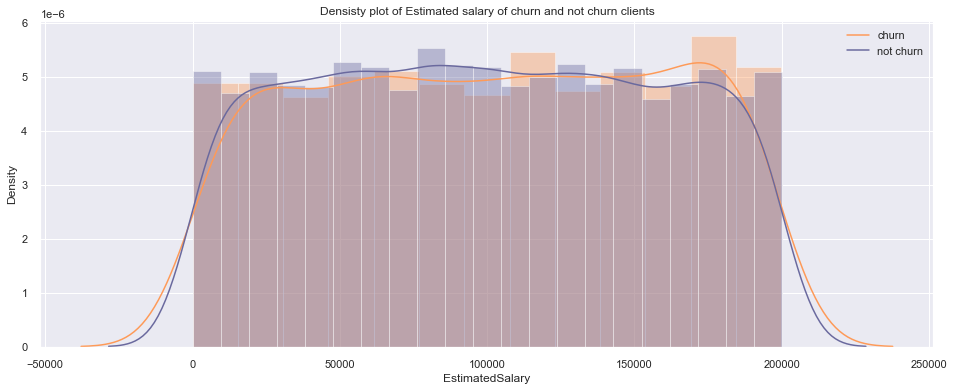

In [367]:
#Density plot of Estimated Salary of churn clients

plt.rcParams['figure.figsize'] = [16, 6]

sns.distplot(df[df['Exited'] == '1']['EstimatedSalary'], label='churn') 
sns.distplot(df[df['Exited'] == '0']['EstimatedSalary'], label='not churn') 

plt.title('Densisty plot of Estimated salary of churn and not churn clients')
plt.legend(['churn', 'not churn']) ;

In [52]:
#EstimatedSalary stats

a = df.groupby(['Exited'])['EstimatedSalary'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a = a.T
a.columns = ['not churn', 'churn']
a = a.T
a

count           mean     median           std    min        max
not churn  7963.0   99738.391772   99645.04  57405.586966  90.07  199992.48
churn      2037.0  101465.677531  102460.84  57912.418071  11.58  199808.10

In [53]:
#Create salaries categories
bins = list(np.arange(0,210000,10000))

df['salary_cat'] = pd.cut(df['EstimatedSalary'], bins=bins)

#Clean characters
df['salary_cat'] = df['salary_cat'].astype('str')
df['salary_cat'] = df['salary_cat'].str.replace('(','')
df['salary_cat'] = df['salary_cat'].str.replace(']','')
df['salary_cat'] = df['salary_cat'].str.split(',', expand=True)[1]
df['salary_cat'] = df['salary_cat'].astype('int')

In [54]:
#EstimatedSalary categories stats

a = df.groupby(['salary_cat'])['EstimatedSalary'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a

count           mean      median          std        min        max
salary_cat                                                                     
10000         508    4960.361024    4794.960  2963.254316      11.58    9984.40
20000         478   14984.639477   14893.015  2935.277490   10008.68   19998.31
30000         492   25063.322683   25327.275  2843.437857   20008.46   29995.83
40000         477   34960.023208   34948.770  2744.678905   30020.09   39934.41
50000         498   45088.420000   45084.855  2939.871860   40014.76   49978.67
60000         508   55050.952205   55086.510  2825.846881   50016.17   59981.62
70000         507   64829.444615   64833.280  2836.050601   60013.17   69903.93
80000         520   75201.085308   75247.255  2940.100281   70007.67   79997.14
90000         510   84993.399843   84923.955  2871.633274   80006.65   89983.02
100000        492   94793.990549   94674.300  2801.697489   90020.74   99984.86
110000        536  104856.989086  104720.580  2893.863557  100015.79  109988.09
120000        491  115119.235825  115227.020  2849.910050  110035.88  119996.95
130000        505  124922.517901  125079.650  2832.192539  120031.29  129984.20
140000        502  134942.592092  134895.645  2880.963319  130001.13  139994.68
150000        521  145040.680269  145115.950  2923.131549  140000.29  149991.32
160000        461  155210.772993  155304.530  2962.510212  150026.79  159938.82
170000        478  165039.702427  164834.705  2846.101762  160060.90  169964.12
180000        531  175049.494576  175161.050  2908.144712  170008.74  179978.68
190000        476  184921.803550  184798.555  2911.300992  180002.42  189995.86
200000        509  195086.763517  195053.580  2912.859419  190011.85  199992.48

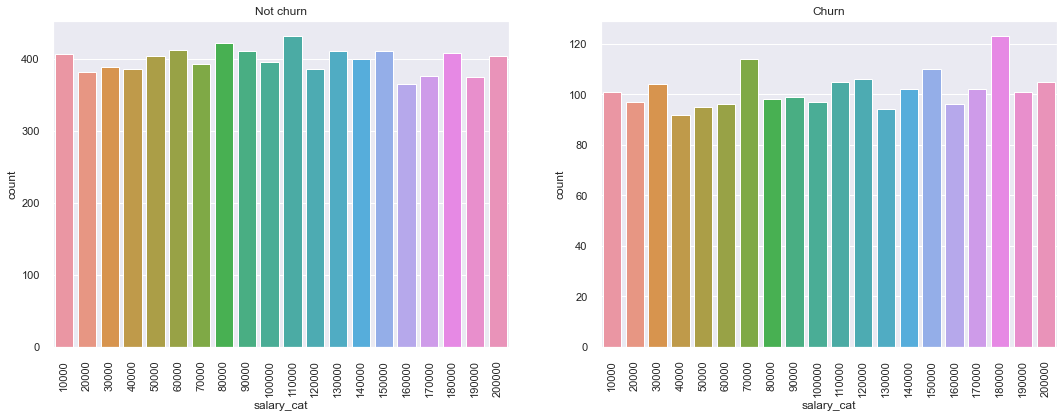

In [368]:
#Plot salary categories
plt.rcParams['figure.figsize'] = [18, 6]

df.sort_values(by='salary_cat', inplace=True)
not_churn = df[df['Exited'] == '0']
churn = df[df['Exited'] == '1']

plt.subplot(1,2,1)
sns.countplot(x='salary_cat', data=not_churn).set_title('Not churn')
plt.xticks(rotation=90) 

plt.subplot(1,2,2)
sns.countplot(x='salary_cat', data=churn).set_title('Churn')
plt.xticks(rotation=90) ;

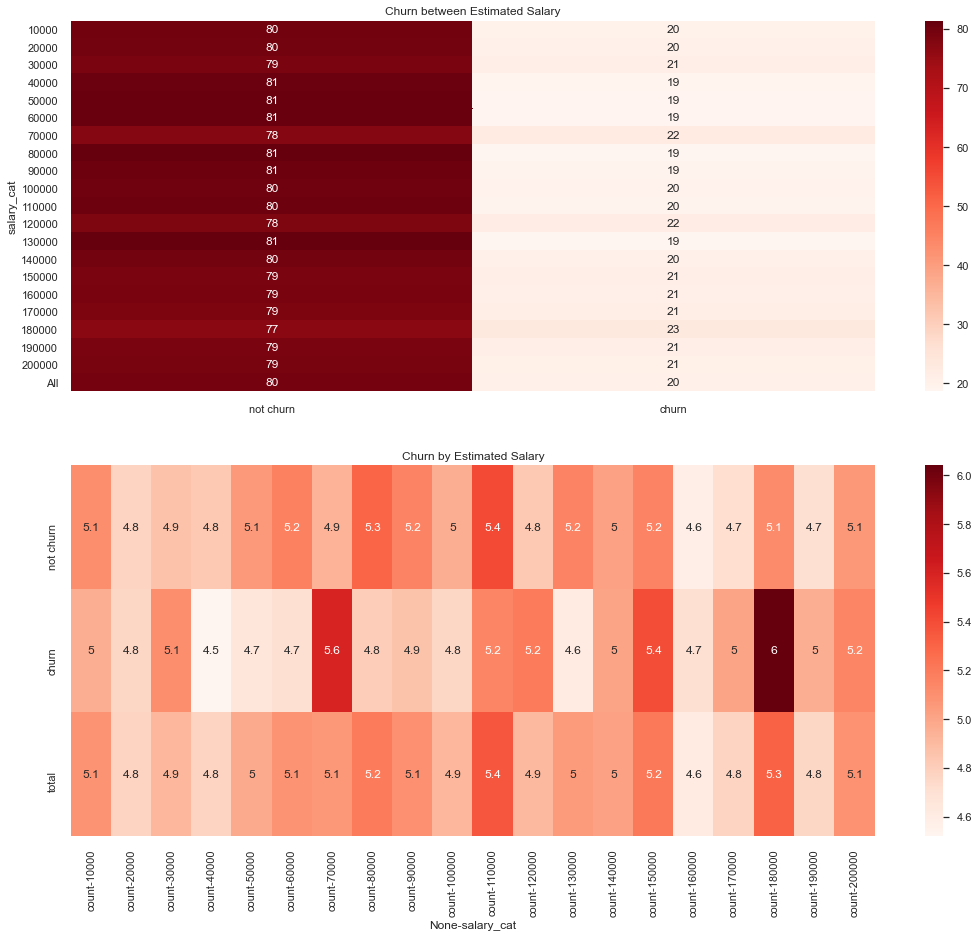

In [56]:
#Estimated salary - Percentage ratio heatmap
plt.subplots(figsize=(18,15))

a = df.pivot_table(values='Gender', index='salary_cat', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
a.drop('total', axis=1, inplace=True)

plt.subplot(2,1,1)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn between Estimated Salary') 

a = df.pivot_table(values='Gender', index='Exited', columns='salary_cat', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T

for col in a.columns:
    a[col] = (a[col]/a[('count', 'All')]*100).round(2)    
a.drop([('count', 'All')], axis=1, inplace=True)

plt.subplot(2,1,2)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by Estimated Salary') ;

#### **H3.** Clients that **have more money in their balance** tend to be churn (*Balance*)

**FALSE**: clients that have **zero balance** have significantly **more chance to be a churn**. Some interesting observations about the **categories with more proportional number of clients**:
- Clients with >10.000 (mostly zero) balance have **-6% more chance to be a churn (14%)** and they are **more than 1/3 of total clients (36%)** 
- All the **categories with more than ~6% of total clients** (excluding the first category >10.000) **have churn tendencies** (categories >100.000 to >150.000) which **correponds to ~45% of total clients**

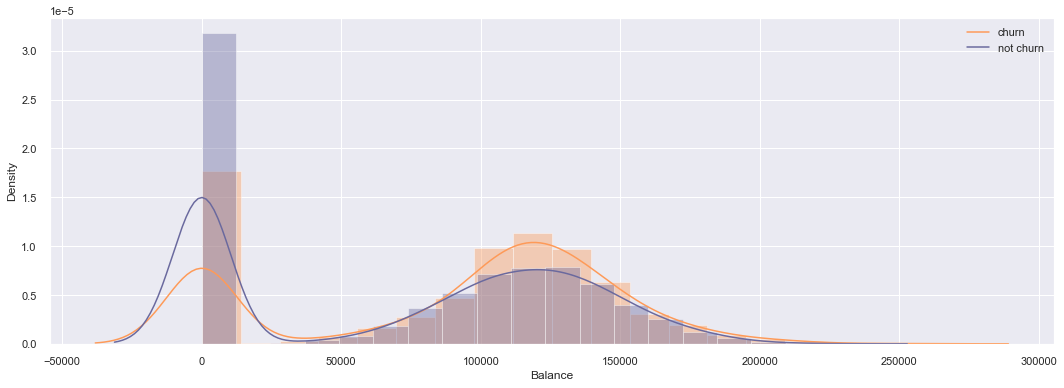

In [370]:
#Density plot of Balance of churn clients

plt.rcParams['figure.figsize'] = [18, 6]

sns.distplot(df[df['Exited'] == '1']['Balance'], label='churn') ;

sns.distplot(df[df['Exited'] == '0']['Balance'], label='not churn') ;

plt.legend(['churn', 'not churn']) ;

In [58]:
#Balance stats

a = df.groupby(['Exited'])['Balance'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a = a.T
a.columns = ['not churn', 'churn']
a = a.T

a

count          mean     median           std  min        max
not churn  7963.0  72745.296779   92072.68  62848.040701  0.0  221532.80
churn      2037.0  91108.539337  109349.29  58360.794816  0.0  250898.09

In [59]:
#Create balance categories

bins = list(np.arange(0,270000,10000))

df['balance_cat'] = pd.cut(df['Balance'], bins=bins, include_lowest=True)

#Clean characters

df['balance_cat'] = df['balance_cat'].astype('str')
df['balance_cat'] = df['balance_cat'].str.replace('(','')
df['balance_cat'] = df['balance_cat'].str.replace(']','')
df['balance_cat'] = df['balance_cat'].str.split(',', expand=True)[1]
df['balance_cat'] = df['balance_cat'].str.strip()
df['balance_cat'] = df['balance_cat'].astype('float')
df['balance_cat'] = df['balance_cat'].astype('int')

In [60]:
#Balance categories stats

a = df.groupby(['balance_cat'])['Balance'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a

count           mean      median          std        min        max
balance_cat                                                                     
10000         3618       1.041650       0.000    62.655058       0.00    3768.69
20000            3   14538.526667   14262.800  2230.021241   12459.19   16893.59
30000            8   27055.372500   27636.560  2155.741163   23503.31   29602.08
40000           17   36732.384706   37266.670  2281.820198   32197.64   39539.39
50000           46   45006.241522   45276.640  2897.129153   40105.51   49572.73
60000           80   55975.771375   56627.715  2796.408835   50194.59   59972.26
70000          156   65255.128654   65261.150  2906.743852   60013.81   69974.66
80000          274   75549.356058   75890.655  2958.705265   70105.87   79974.55
90000          400   85069.765525   84925.515  2905.524809   80001.23   89994.71
100000         599   95441.026795   95808.190  2886.638258   90018.45   99986.98
110000         786  105211.491718  105265.600  2856.252699  100013.51  109978.83
120000         832  115016.607764  115080.295  2844.414219  110022.74  119984.07
130000         898  125036.172584  124994.635  2885.562113  120018.86  129991.76
140000         734  134985.130000  134907.940  2918.427248  130013.12  139994.66
150000         580  144819.605500  144850.400  2841.459522  140002.35  149995.72
160000         386  154388.827798  154182.790  2681.581137  150005.38  159904.79
170000         264  164764.521250  164864.495  2841.805744  160132.75  169988.35
180000         159  174594.881635  174701.050  2948.273890  170008.84  179960.20
190000          86  184493.462791  184701.135  2665.345950  180075.22  189443.72
200000          40  193294.876750  191993.675  3129.329570  190008.32  199689.49
210000          21  204654.924762  204510.940  2918.428488  200117.76  209767.31
220000           9  212921.327778  212696.320  1590.949352  210433.08  216109.88
230000           2  221900.215000  221900.215   519.603276  221532.80  222267.63
240000           1  238387.560000  238387.560          NaN  238387.56  238387.56
260000           1  250898.090000  250898.090          NaN  250898.09  250898.09

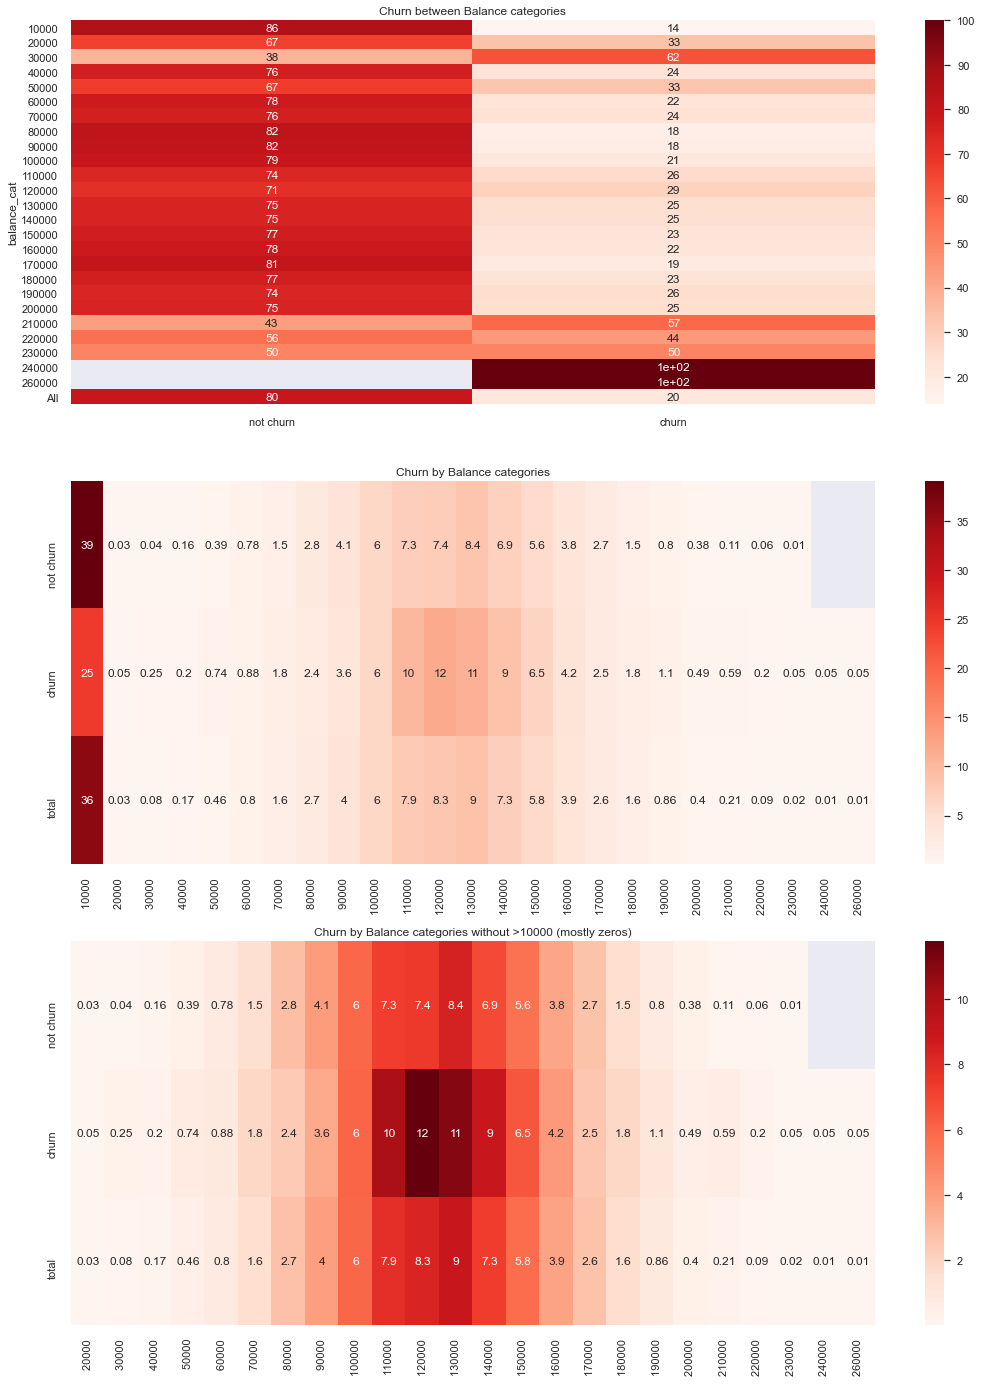

In [61]:
#Balance - Percentage ratio heatmap
plt.subplots(figsize=(18,24))

a = df.pivot_table(values='Gender', index='balance_cat', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
a.drop('total', axis=1, inplace=True)

plt.subplot(3,1,1)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn between Balance categories') 

a = df.pivot_table(values='Gender', index='Exited', columns='balance_cat', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T


for col in a.columns:
    a[col] = (a[col]/a[('count', 'All')]*100).round(2)    
a.drop([('count', 'All')], axis=1, inplace=True)
cols = pd.Series(list(a.columns))
cols = cols.astype('str')
cols = cols.str.replace('(','')
cols = cols.str.replace(')','')
cols = cols.str.split(',', expand=True)[1]
a.columns = list(cols)

plt.subplot(3,1,2)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by Balance categories') 

plt.subplot(3,1,3)
a.drop([' 10000'], axis=1, inplace=True) 
sns.heatmap( a, annot=True, cmap='Reds').set_title('Churn by Balance categories without >10000 (mostly zeros)') ;

#### **H4.** Clients with greater **tenure** do not tend to be a churn (*Tenure*)

**TRUE**: clients with a **greater tenure have a slightly less chance to be a churn**; before the first year, **zero tenure**, the **churn rate is 3% higher (23%)** and in the **first year is 2% higher (22%)**. Then, the **churn rate declines to below average (-1% or 19%) or average (0% or 20%) throughout the third to the six year**. After that, the rate increases and declines again  

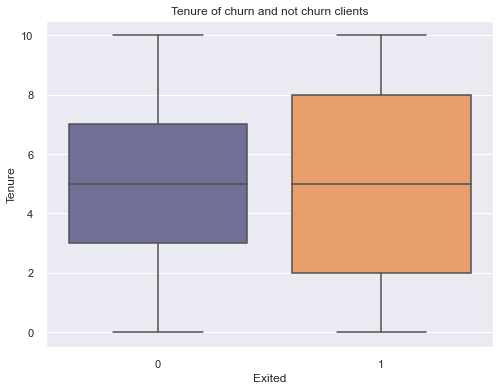

In [371]:
#Summary boxplot of Tenure of exiting
colors = ['#6a699e', '#fe9a58']
sns.set_palette(sns.color_palette(colors))

plt.rcParams['figure.figsize'] = [8, 6]

sns.boxplot(x='Exited', y='Tenure', data=df).set_title('Tenure of churn and not churn clients') ;

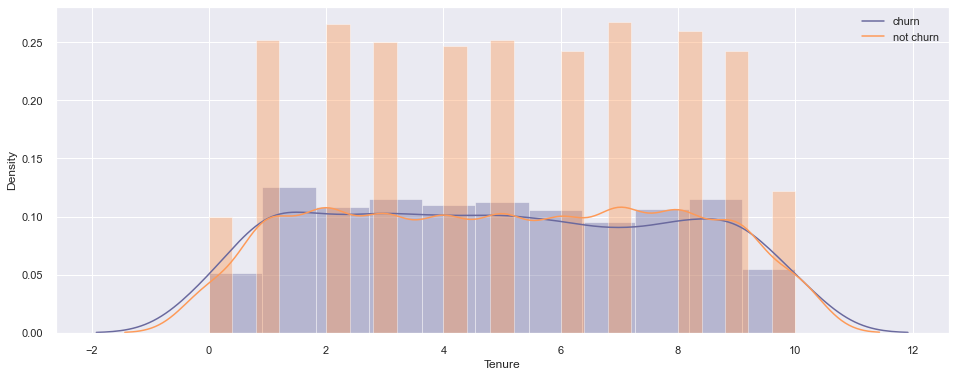

In [374]:
#Density plot of Tenure of churn clients

plt.rcParams['figure.figsize'] = [16, 6]

sns.distplot(df[df['Exited'] == '1']['Tenure'], label='churn') 
sns.distplot(df[df['Exited'] == '0']['Tenure'], label='not churn') 
plt.legend(['churn', 'not churn']) ;

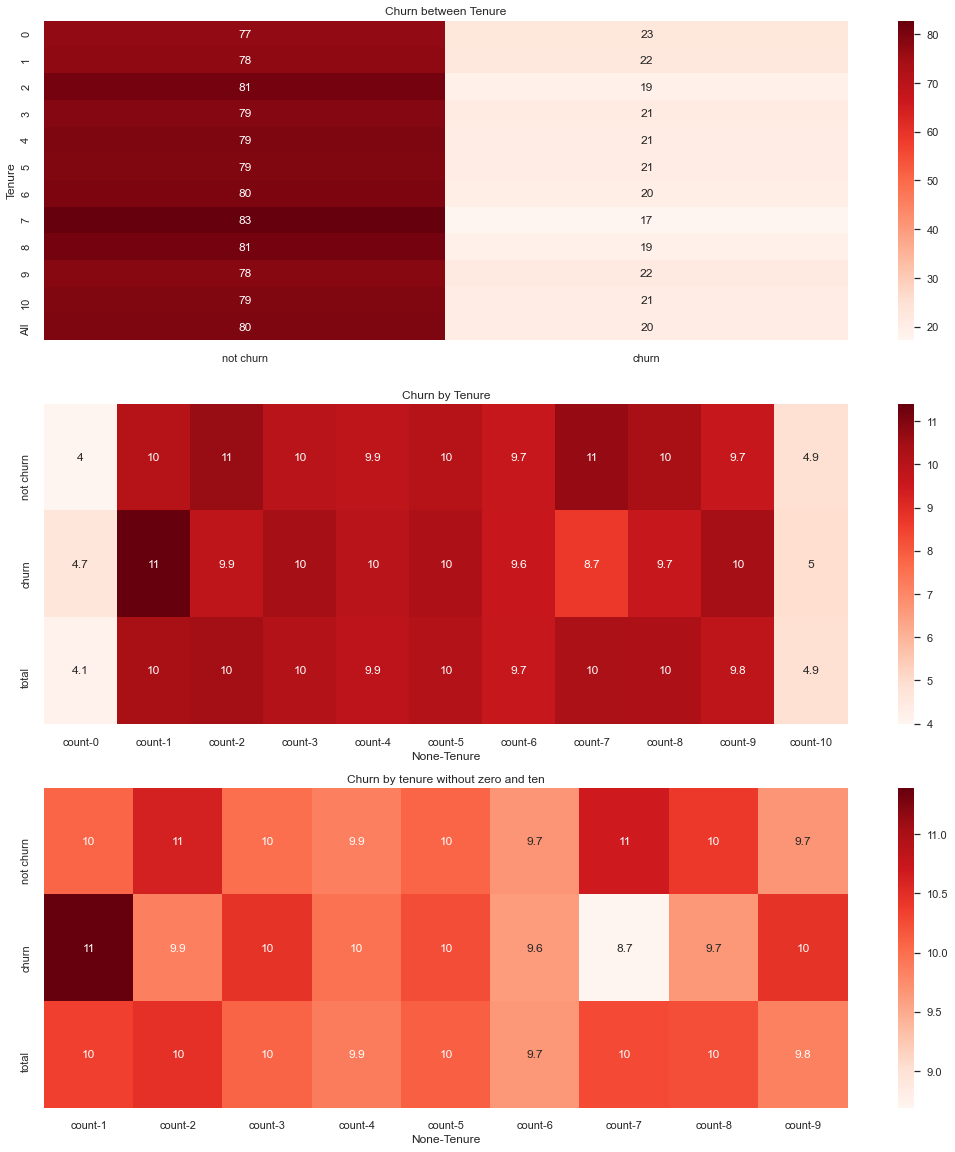

In [64]:
#Tenure - Percentage ratio heatmap
plt.subplots(figsize=(18,20))

a = df.pivot_table(values='Gender', index='Tenure', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
a.drop('total', axis=1, inplace=True)

plt.subplot(3,1,1)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn between Tenure') 

a = df.pivot_table(values='Gender', index='Exited', columns='Tenure', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T

for col in a.columns:
    a[col] = (a[col]/a[('count', 'All')]*100).round(2)    
a.drop([('count', 'All')], axis=1, inplace=True)

plt.subplot(3,1,2)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by Tenure') 

plt.subplot(3,1,3)
a.drop([('count',  0),('count', 10)], axis=1, inplace=True) 
sns.heatmap( a, annot=True, cmap='Reds').set_title('Churn by tenure without zero and ten') ;

#### **H5.** Clients that have a greater **number of products** do not tend to be a churn (*NumOfProducts*)

**TRUE**: the churn rate of **clients with only 01 product**, that corresponds to **51% of total clients**, is **8% higher than average**; the churn rate of **clients that have 02 produtcs**, that corresponds to **46% to total clients**, is **-12,4% less than average**. Clients with **more than 03 products together** sum **less than 3,5% of total clients**, therefore the apparently high churn rate is **not so relevant**

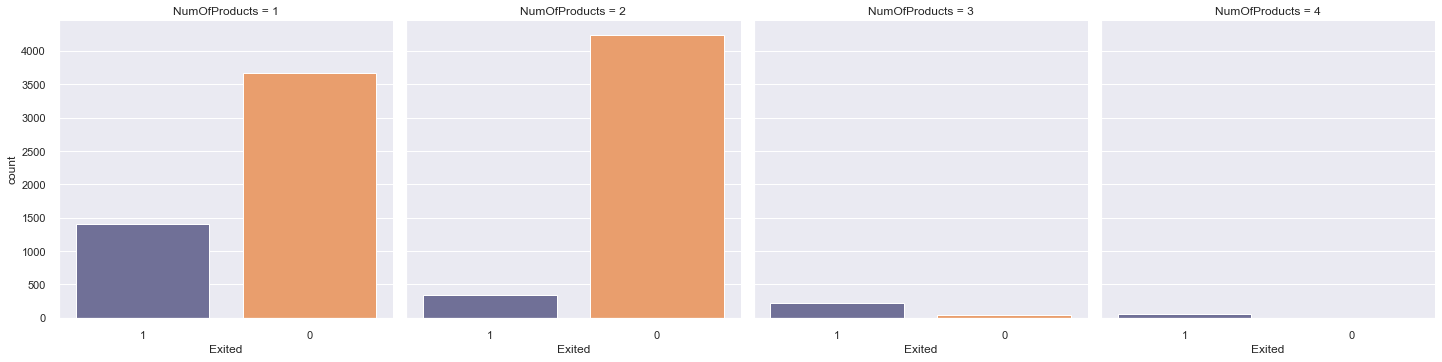

In [65]:
#NumOfProducts - countplot

sns.catplot(x='Exited', data=df, kind='count', col='NumOfProducts', legend=True) ;

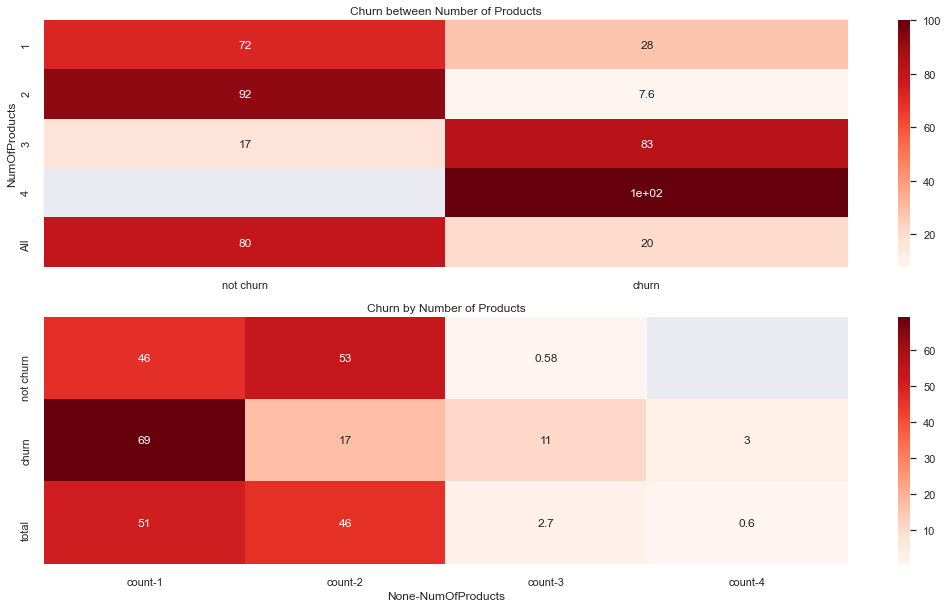

In [66]:
#NumOfProducts - Percentage ratio heatmap
plt.subplots(figsize=(18,10))

a = df.pivot_table(values='Gender', index='NumOfProducts', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
a.drop('total', axis=1, inplace=True)

plt.subplot(2,1,1)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn between Number of Products') 

a = df.pivot_table(values='Gender', index='Exited', columns='NumOfProducts', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T

for col in a.columns:
    a[col] = (a[col]/a[('count', 'All')]*100).round(2)    
a.drop([('count', 'All')], axis=1, inplace=True)

plt.subplot(2,1,2)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by Number of Products') ;

#### **H6.** **Older people** tend to be a churn (*Age*)

**TRUE**: as predicted in the correlation analysis, the **age feature has a very clear tendency about churn clients**; looking at the data, we see that **older clients have a greater tendency to be churn**, conclusions:
- In the **categories of age >23 to >43**, the churn rate is way less than average; the **lowest rate is -12,8% (7,2%) between clients of 25 and 28 years old** (>28 category). Luckly, **these categories together** account for **~74% of total clients**
- **Older clients of categories >48 and beyond** have high exiting tendencies since the **churn rate is way above the average**; the **highest rate is +37% (57%) between clients of 55 and 58 years** old (>58 category). **Minor fluctuations** as clients get even more old in churn rate shouldn't have much impact since **these categories have very few clients**

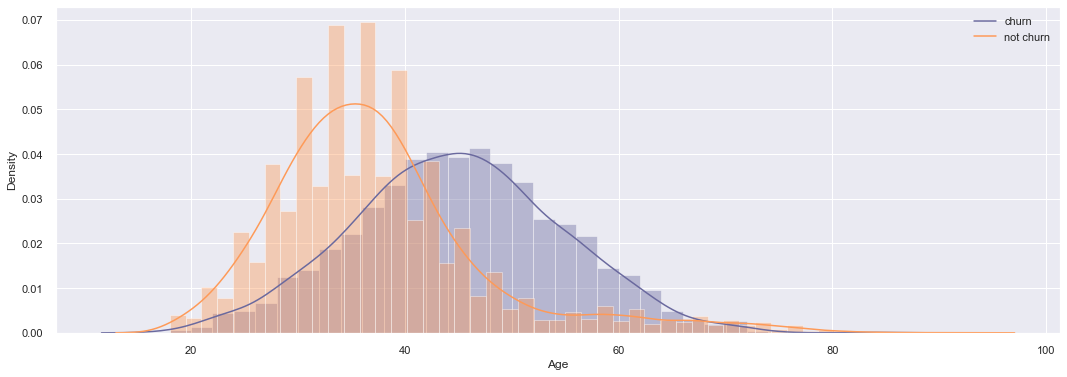

In [67]:
#Density plot - Age of churn clients

plt.rcParams['figure.figsize'] = [18, 6]

sns.distplot(df[df['Exited'] == '1']['Age'], label='churn') 
sns.distplot(df[df['Exited'] == '0']['Age'], label='not churn') 
plt.legend(['churn', 'not churn']) ;

In [68]:
#Create age categories

bins = list(np.arange(18,94,5))
df['age_cat'] = pd.cut(df['Age'], bins=bins, include_lowest=True)

#Clean characters
df['age_cat'] = df['age_cat'].astype('str')
df['age_cat'] = df['age_cat'].str.replace('(','')
df['age_cat'] = df['age_cat'].str.replace(']','')
df['age_cat'] = df['age_cat'].str.split(',', expand=True)[1]
df['age_cat'] = df['age_cat'].str.strip()
df['age_cat'] = df['age_cat'].astype('float')
df['age_cat'] = df['age_cat'].astype('int')

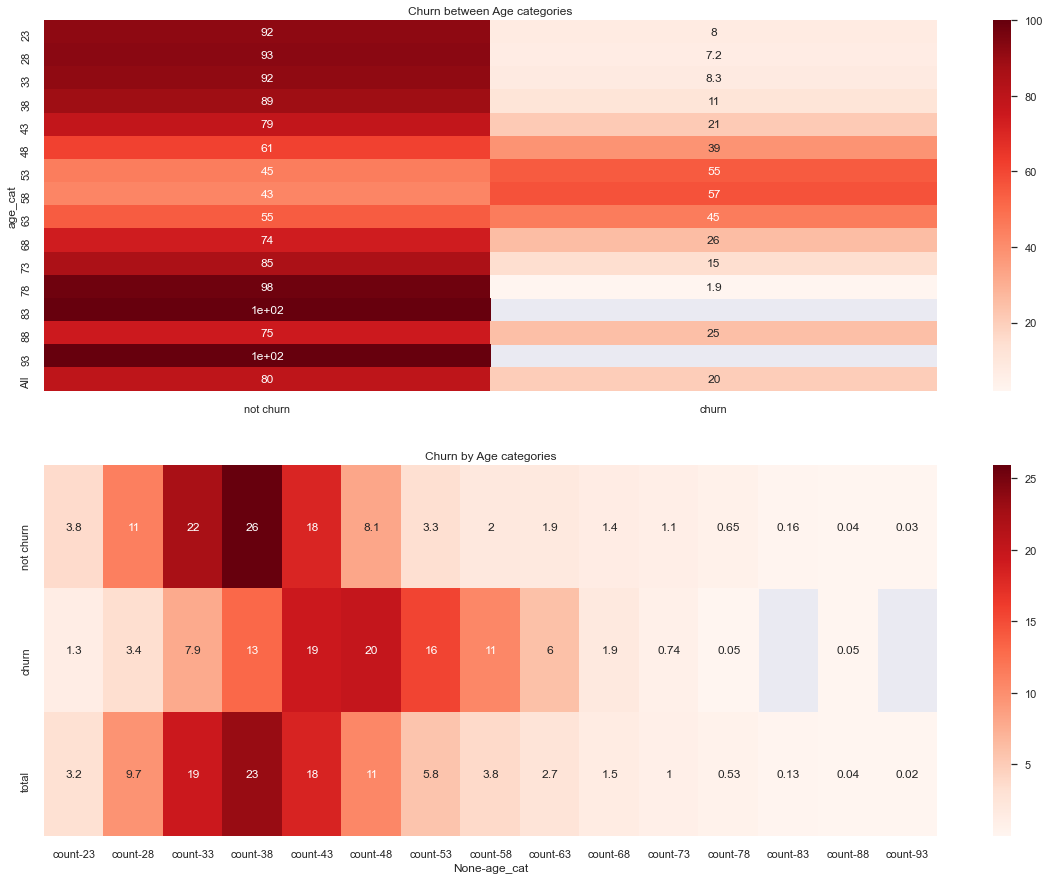

In [69]:
#Age categories - Percentage ratio heatmap
plt.subplots(figsize=(20,15))

a = df.pivot_table(values='Gender', index='age_cat', columns='Exited', aggfunc=['count'], margins=True)
a.columns = ['not churn', 'churn', 'total']

for col in a.columns:
    a[col] = (a[col]/a['total']*100).round(2)
a.drop('total', axis=1, inplace=True)

plt.subplot(2,1,1)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn between Age categories') 

a = df.pivot_table(values='Gender', index='Exited', columns='age_cat', aggfunc=['count'], margins=True)
a = a.T
a.columns = ['not churn', 'churn', 'total']
a = a.T

for col in a.columns:
    a[col] = (a[col]/a[('count', 'All')]*100).round(2)    
a.drop([('count', 'All')], axis=1, inplace=True)

plt.subplot(2,1,2)
sns.heatmap(a, annot=True, cmap='Reds').set_title('Churn by Age categories') ;

### Hyphotesis summary 

**H1.** **FALSE** - *Importance: low*    - Clients that have a bad **Credit Score** do tend to be a churn (*CreditScore*) 

**H2.** **TRUE**  - *Importance: medium* - Clients with a greater anual **Estimated Salary** do tend to be churns (*EstimatedSalary*) 

**H3.** **TRUE**  - *Importance: medium* - Clients with greater **tenure** do not tend to be a churn (*Tenure*) 

**H4.** **FALSE** - *Importance: medium* - Clients that **have more money in their balance** tend to be churn (*Balance*) 

**H5.** **TRUE**  - *Importance: high*   - Clients that have a greater **number of products** do not tend to be a churn (*NumOfProducts*) 

**H6.** **TRUE**  - *Importance: high*   - **Older people** tend to be a churn (*Age*) 



# 3.0 Feature engineering

## 3.1 Create new features

**The goal** of the new features is to **aggregate information** of two columns, or even just one column under a new optic, to **help the algorithm find relevant information to predict the target variable**. There is **the risk to fall under the trap of collinearity** and just **add noise to the model**. Therefore, the **feature relevance algorithm Boruta** will tell us after **if they are relevant to the model** 

Here, the new features are **going to be based on the features** that, in isolation, **have more correlation with the target variable**. These features are:  ***Age***, ***Balance*** and ***NumOfProducts***

In [70]:
#Create the new features - Age, Balance and NumOfProducts

df['balance/age'] = df['Balance'] / df['Age'] 
df['num_of_prod/age'] = df['Age'] / df['NumOfProducts']
df['balance/num_of_prod'] = df['Balance'] /  df['NumOfProducts']

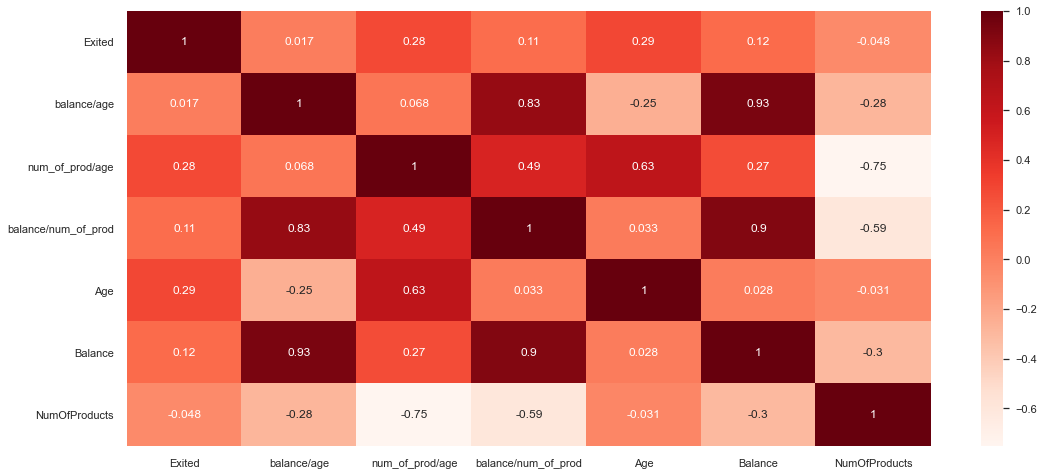

In [71]:
#Evaluation of feature engeneering

df['Exited'] = df['Exited'].astype('int')
df_corr = df[['Exited', 'balance/age', 'num_of_prod/age', 'balance/num_of_prod','Age', 'Balance', 'NumOfProducts']]

plt.rcParams['figure.figsize'] = [18, 8] #See if there is figuresize argument

correlation = df_corr.corr( method='pearson')

sns.heatmap(correlation, annot=True, cmap='Reds');

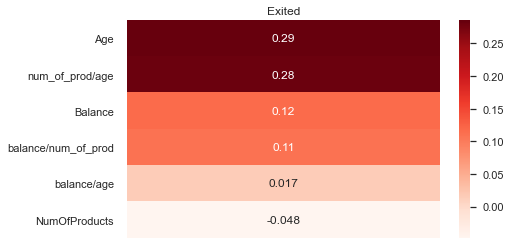

In [375]:
#See the result in correlation to the target variable 

plt.subplots(figsize=(7,4))

plot_corr('Exited') ;

## 3.2 Rescaling

Some algorithms need the **data to be on the same scale** because, if they are in different scales, there is a **chance that the they will have an artificial greater importance** to variables because greater range and this will potentially **disturb the model performance**

Here, the **StandardScaler** is going to be **used to the only variable with normal distribution (*CreditScore*)** and the **MinMaxScaler** to **all the other variables** that are not in the form of a normal distribution, **since they don't have much outliers influence**

In [73]:
#Copy the DataFrame to rescale

df3 = df.drop(['credit_cat','salary_cat', 'balance_cat', 'age_cat'], axis=1)

In [74]:
#Standard Scaler - CreditScore

std = StandardScaler()

df3['CreditScore'] = std.fit_transform(df3[['CreditScore']].values)

In [75]:
#Min-Max Scaler - Balance, Age, Tenure

mms = MinMaxScaler()

df3['Balance'] = mms.fit_transform(df3[['Balance']].values)

df3['Age'] = mms.fit_transform(df3[['Age']].values)

df3['Tenure'] = mms.fit_transform(df3[['Tenure']].values)

df3['EstimatedSalary'] = mms.fit_transform(df3[['EstimatedSalary']].values)

df3['NumOfProducts'] = mms.fit_transform(df3[['NumOfProducts']].values)

df3['balance/age'] = mms.fit_transform(df3[['balance/age']].values)

df3['num_of_prod/age'] = mms.fit_transform(df3[['num_of_prod/age']].values)

df3['balance/num_of_prod'] = mms.fit_transform(df3[['balance/num_of_prod']].values)

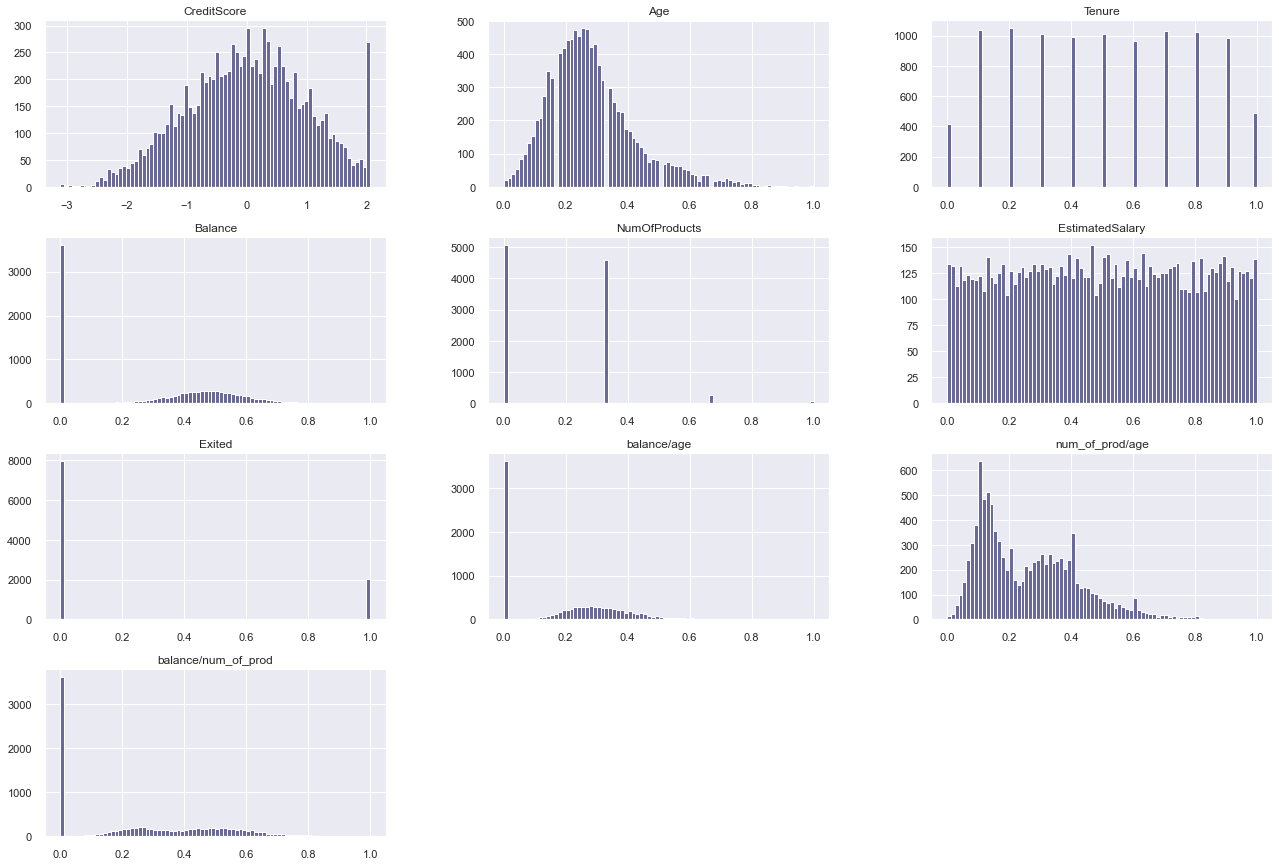

In [76]:
#Check if distribution is still the same 

plt.rcParams['figure.figsize'] = [22, 15]

df3.hist(bins=80) ;

## 3.3 Encoding

The majority of Machine Learning Models don't accept strings as inputs, so it is important to **convert the categorical string features into numerical values**

Here, **One Hot Encoding** will be the encoding strategy because it works for variables that have **low cardinality** (number of classes) and pass the **idea of distinct circumstances**. The categorical features ***Geography*** and ***Gender*** match these characteristics

In [77]:
#Transform strings into numbers

d = {'yes':1,'no':0}

df3['HasCrCard'] = df3['HasCrCard'].map(d)
df3['IsActiveMember'] = df3['IsActiveMember'].map(d)

In [78]:
#One hot encoding - Geography and Gender

df3 = pd.get_dummies(df3, prefix=['geo'], columns=['Geography'])  
df3 = pd.get_dummies(df3, prefix=['gender'], columns=['Gender'])

## 3.4 Balancing data

The proportion of ***churn clients* is 20%** while ***not churn* clients correspond to 80%**. Since the **target variable** is **not balanced**, the Machine Learning algorithms will have **more examples** of the **not churn class** than of the **churn class**  

Hence, the **model could learn how to predict better** the ***not churn* class** — which is ***not*** the goal. To prevent this issue to happen, the **data is going be balanced with an algorithm** — Smote Tomek — that uses oversampling (an statistical tool) **to match the proportion of the two classes**

In [331]:
#Split into training and test data

X = df3.drop('Exited', axis=1)
y = df3['Exited']

X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, test_size=0.4, random_state=123, stratify=y)

In [332]:
#Balance dataset
resampler = SMOTETomek(random_state=123, n_jobs=-1)

X_train, y_train = resampler.fit_resample(X_train_imb, y_train_imb)

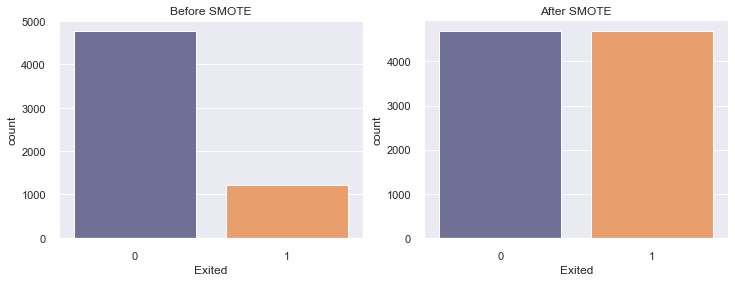

In [377]:
#Plot Before and after
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train_imb).set_title('Before SMOTE')

plt.subplot(1,2,2)
sns.countplot(x=y_train).set_title('After SMOTE') ;

In [333]:
#Catboost - create specific dataframe 
df_cat = df3.copy()
df_cat['NumOfProducts'] = df['NumOfProducts']
df_cat['Tenure'] = df['Tenure'] 

In [334]:
#CatBoost - Train test split

X_cat = df_cat.drop('Exited', axis=1)
y_cat = df_cat['Exited']

X_train_cat_imb, X_test_cat, y_train_cat_imb, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.4, random_state=123, stratify=y)

In [335]:
#CatBoost - Balance dataset
resampler = SMOTETomek(random_state=123, n_jobs=-1)

X_train_cat, y_train_cat = resampler.fit_resample(X_train_cat_imb, y_train_cat_imb)

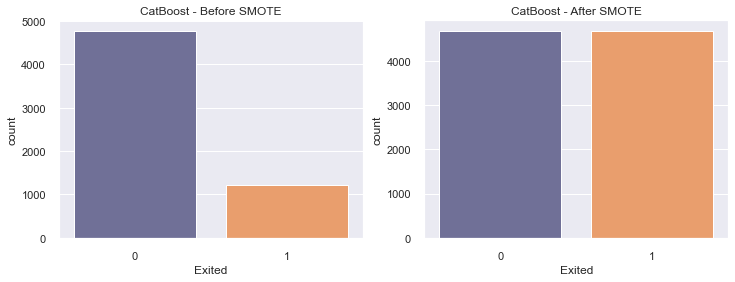

In [378]:
#Plot Before and after
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train_cat_imb).set_title('CatBoost - Before SMOTE')

plt.subplot(1,2,2)
sns.countplot(x=y_train_cat).set_title('CatBoost - After SMOTE') ;

## 3.5 Selecting features

The **feature selection** is going to be done by the **Boruta algorithm** that is built specifically to find correlations between the features and the target variable. The goal is to see which variables Boruta finds relevant through the **Random Forest** model and then **see if it makes sense with the Exporatatory Data Analysis**

### 3.5.1 Boruta

The features Boruta rejected are: 

- ***'HasCrCard'***: having credit cards doesn't impact much in in churn and not churn ratio so **it is also in accordance with the EDA**
- ***'IsActiveMember'***: being an active member does have an impact in churn, so it is **not in accordance with the EDA**
- ***'gender_Female'*** and ***'gender_Male'***: women has a greater tendency to be a churn than men, so it is **not in accordance with the EDA**
- ***'geo_France'***, ***'geo_Germany'***, ***'geo_Spain'***: Germany clients has a greater tendency to be a churn **not in accordance with the EDA since**


In [302]:
#Boruta

rf = RandomForestClassifier(n_estimators= 300, n_jobs=-1, random_state=123)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=123).fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	7


In [303]:
#Boruta - results

cols_selected = boruta.support_.tolist()

cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list( np.setdiff1d(X_train.columns, cols_selected_boruta))

In [304]:
#Boruta - columns selected

cols_selected_boruta

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'balance/age',
 'num_of_prod/age',
 'balance/num_of_prod']

In [305]:
#Boruta - columns not selected

cols_not_selected_boruta

['HasCrCard',
 'IsActiveMember',
 'gender_Female',
 'gender_Male',
 'geo_France',
 'geo_Germany',
 'geo_Spain']

### 3.5.3 Conclusion

After analysing the relevant features of these two models, according to **Boruta** and the **Exploratory Data Analysis**, the features removed are going to be: ***'CreditScore'***, ***'credit_cat'*** and ***'HasCrCard'***

In [336]:
#Delete columns

X_train.drop(['CreditScore', 'HasCrCard'], axis=1, inplace=True)
X_train_cat.drop(['CreditScore', 'HasCrCard'], axis=1, inplace=True)

X_test.drop(['CreditScore', 'HasCrCard'], axis=1, inplace=True)
X_test_cat.drop(['CreditScore', 'HasCrCard'], axis=1, inplace=True)

# 4.0 Machine Learning Modelling

Three different algorithms are going to be used to predict the target variable:

***Logistic Regression***: uses a complex **cost function**, which can be defined as the ***Sigmoid function***. The **output of the classification** is **based on the probability score** between 0 and 1 of the **input being in one class or another** according to a threshold

***Random Forest***: it is a **tree based model** build with **multiple ensamble decision trees** created with the **bagging method**. Then, all the classifiers take a **weighted vote on their predictions**. Since the algorithm goal **is not trying to find a linear function** to describe the event, it **works for problems with more complex behaviour**

***XGBoost***: it is also a **tree based model** but they are **built in a different way**. While Random Forests builds each tree independently, **XGBoost builds one tree at the time learning with its predecessor**. Therefore, this algorithm **doesn't combine results at the end** of the process by taking majority votes, it **combines the results along the way**

***Cat Boost***: this model share the **same logic of XGBoost**, however the **focus is in optimizing the decision trees for categorical variables**. The goal is to work better with features with classes that **have relation with one another like, for example, different colors**  

## 4.1 Fit the algorithms to the data 

In [88]:
#Logistic Regression

reg = LogisticRegression(random_state=123)
reg.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [89]:
#Random Forest

rf = RandomForestClassifier(n_estimators=500, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=123)

In [90]:
#XGBoost

xgb = XGBClassifier(n_estimators=500, random_state=123, n_jobs=-1, eval_metric='logloss')

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [91]:
#CatBoost

df_categories = ['NumOfProducts', 'IsActiveMember', 'Tenure', 'geo_France', 'geo_Germany', 'geo_Spain', 'gender_Female', 'gender_Male']               

params = {'iterations':500, 'random_seed':123, 'cat_features':df_categories, 'eval_metric':'BalancedAccuracy', 'verbose':False}

cat_boost = CatBoostClassifier(**params)

cat_boost.fit(X_train_cat, y_train_cat, eval_set=(X_test_cat, y_test_cat), use_best_model=True, plot=False)


## 4.2 Compare results 

Now, the **out of the box performance** of the **Machine Learning models are going to be compared** to see which is better, before any hyperparameter fine tuning 

### 4.2.1 Class prediction graph 

This graph is **shows the True Class and the Actual Predicted Classes**. It is very intuitive and **gives a good first overview of the performance** of the models

**Conclusion**: visually the **Random Forest** and **CatBoost** algorithms seem to have a **better performance** in predicting churn clients

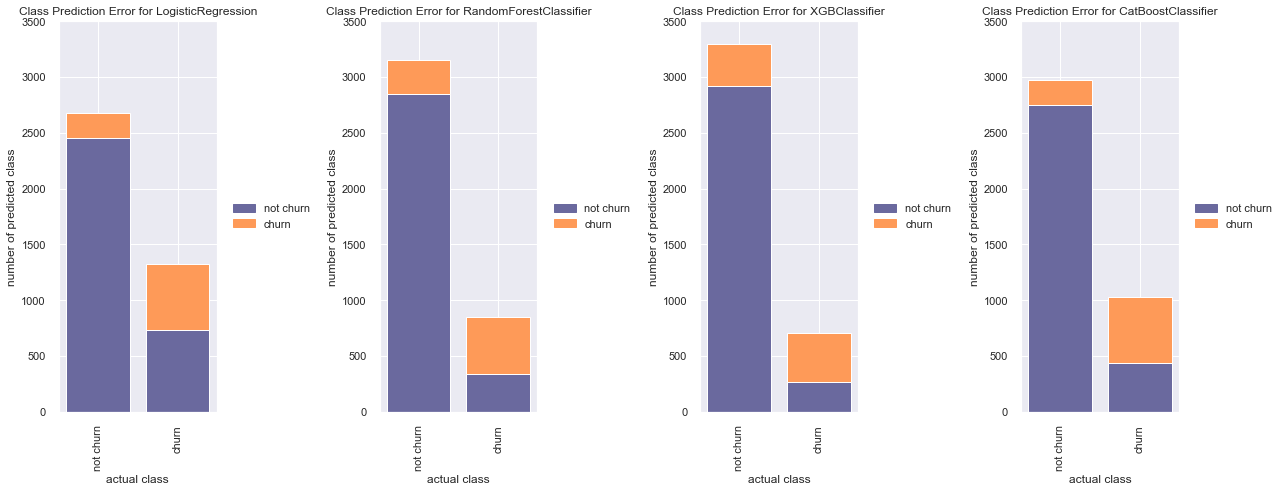

In [142]:
#Plot Class prediction graph

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4,figsize=(20, 7))

visualizer = ClassPredictionError(reg, classes=['not churn', 'churn'], ax=ax1)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ClassPredictionError(rf, classes=['not churn', 'churn'], ax=ax2)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
g = visualizer.finalize()

visualizer = ClassPredictionError(xgb, classes=['not churn', 'churn'], ax=ax3)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
g = visualizer.finalize()

visualizer = ClassPredictionError(wrap(cat_boost), classes=['not churn', 'churn'], ax=ax4)
visualizer.fit(X_train_cat, y_train_cat)  
visualizer.score(X_test_cat, y_test_cat) 
g = visualizer.finalize()

### 4.2.2 Confusion matrix 

The confusion matrix shows the actual number of the **True Class** and the **Predicted Class** for comparison

**Conclusion**: The algorithms **Random Forest** and **CatBoost** had very **similar performances**, as we also saw in the previous graph. **CatBoost performed slightly better** on predicting **churn clients**

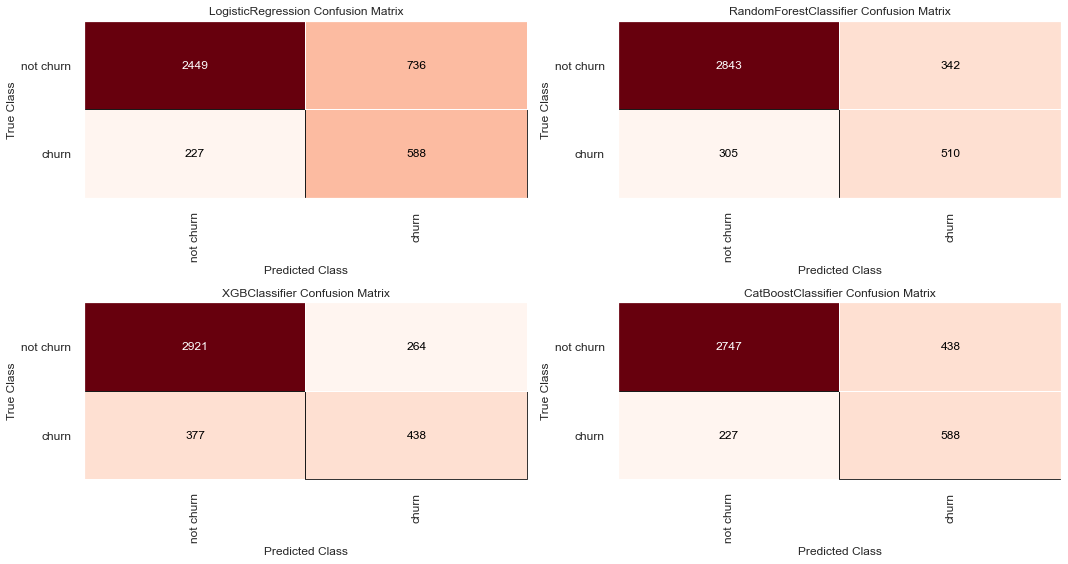

In [143]:
#Confusion matrix
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 8))

visualizer = ConfusionMatrix(reg, classes=['not churn', 'churn'], support=True, ax=ax1, cmap='Reds')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(rf, classes=['not churn', 'churn'], support=True, ax=ax2, cmap='Reds')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(xgb, classes=['not churn', 'churn'], support=True, ax=ax3, cmap='Reds')
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ConfusionMatrix(wrap(cat_boost), classes=['not churn', 'churn'], support=True, ax=ax4, cmap='Reds')
visualizer.fit(X_train_cat, y_train_cat)  
visualizer.score(X_test_cat, y_test_cat)  
g = visualizer.finalize()

### 4.2.3 Classification report 

The classification report shows the **Precision**, **Recall** and **F1 score** (harmonic mean between precision and recall) 

**Conclusion**: ***CatBoost* performed slightly better on metrics**, specifically on predicting **churn clients class** with better **Recall (0.721)** and **F1 (0.639)** metrics

<img src="files/precision_recall.png">

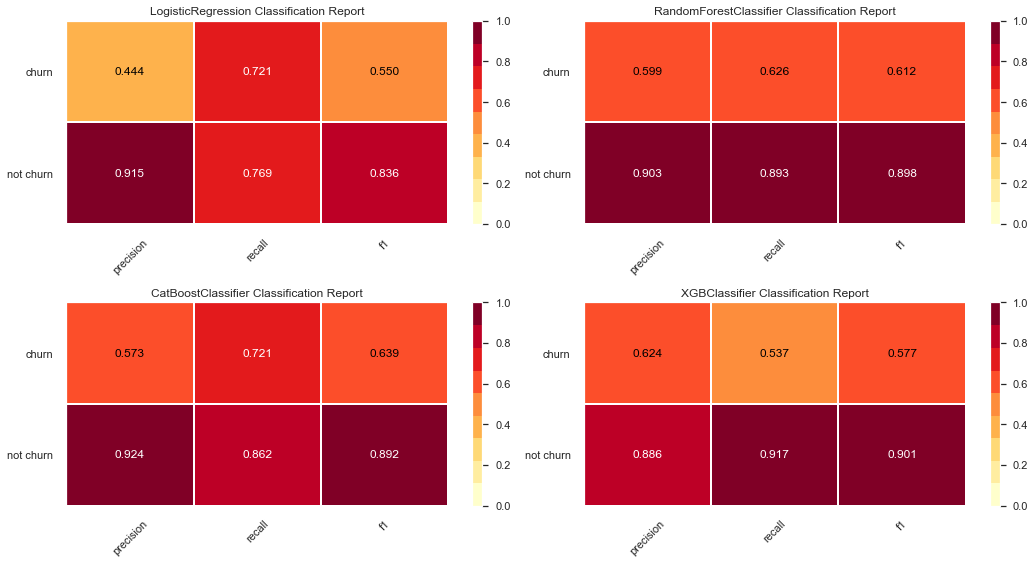

In [144]:
#Classification report
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 8))

visualizer = ClassificationReport(reg,  classes=['not churn', 'churn'], support=False, ax=ax1)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ClassificationReport(rf,  classes=['not churn', 'churn'], support=False, ax=ax2)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

visualizer = ClassificationReport(wrap(cat_boost),  classes=['not churn', 'churn'], support=False, ax=ax3)
visualizer.fit(X_train_cat, y_train_cat)  
visualizer.score(X_test_cat, y_test_cat)  
g = visualizer.finalize()

visualizer = ClassificationReport(xgb,  classes=['not churn', 'churn'], support=False, ax=ax4)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.finalize()

### 4.2.4 ROC AUC Curve 

The **Receiver Operating Characteristic Curve** shows the performance of a model at all **classification thresholds**. The **Area Under the Curve** shows how much the algorithm is capable of distinguishing between classes

**Conclusion**: ***CatBoost*** has a slightly better **Area Under the Curve of 0.87** 

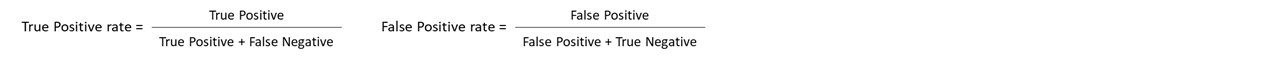

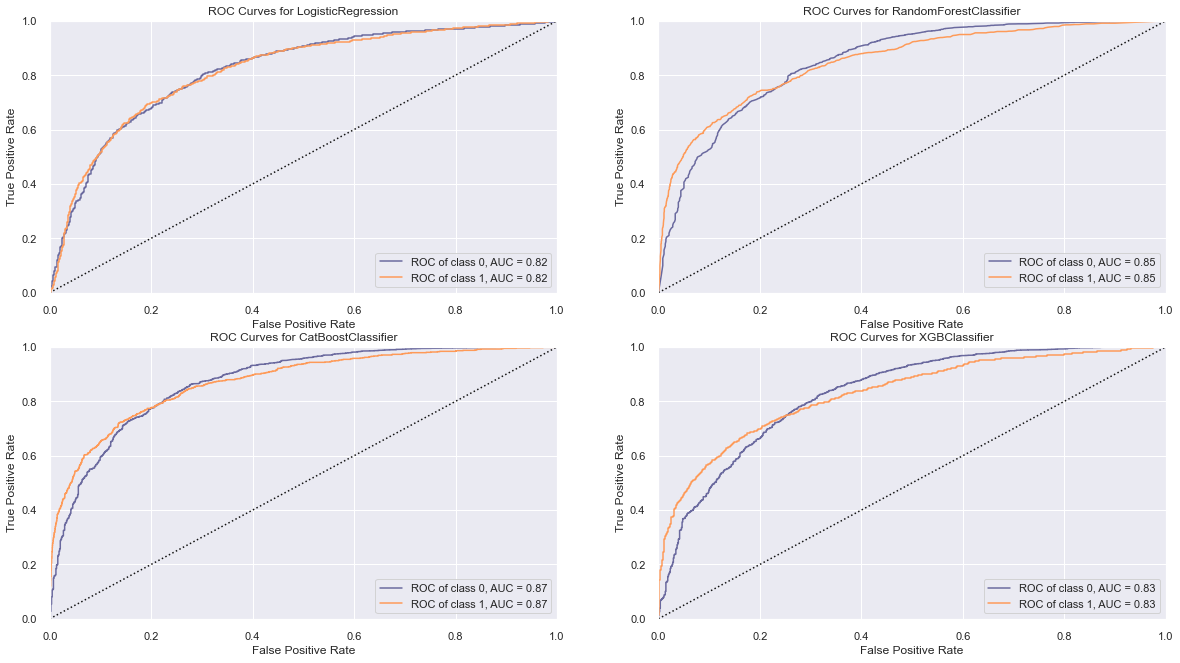

In [149]:
#ROC AUC ccurve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = ROCAUC(reg, iso_f1_curves=True, micro=False, macro=False, ax=ax1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(rf, iso_f1_curves=True, micro=False, macro=False, ax=ax2)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = ROCAUC(wrap(cat_boost), iso_f1_curves=True, micro=False, macro=False, ax=ax3)
viz.fit(X_train_cat, y_train_cat)
viz.score(X_test_cat, y_test_cat)
viz.finalize()

viz = ROCAUC(xgb, iso_f1_curves=True, micro=False, macro=False, ax=ax4)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

### 4.2.5 Precision-recall curve 

To analyse **Precision** and **Recall** is useful here because there is an **imbalance between churn and not churn clients**. This graph also shows the **F1 scores** (harmonic mean between precision and recall), therefore, **the closer the curve gets to the F1 thresholds the better**

**Conclusion**:  ***CatBoost*** has a slightly better **Average Precision of 0.71** 

<img src="files/precision_recall.png">

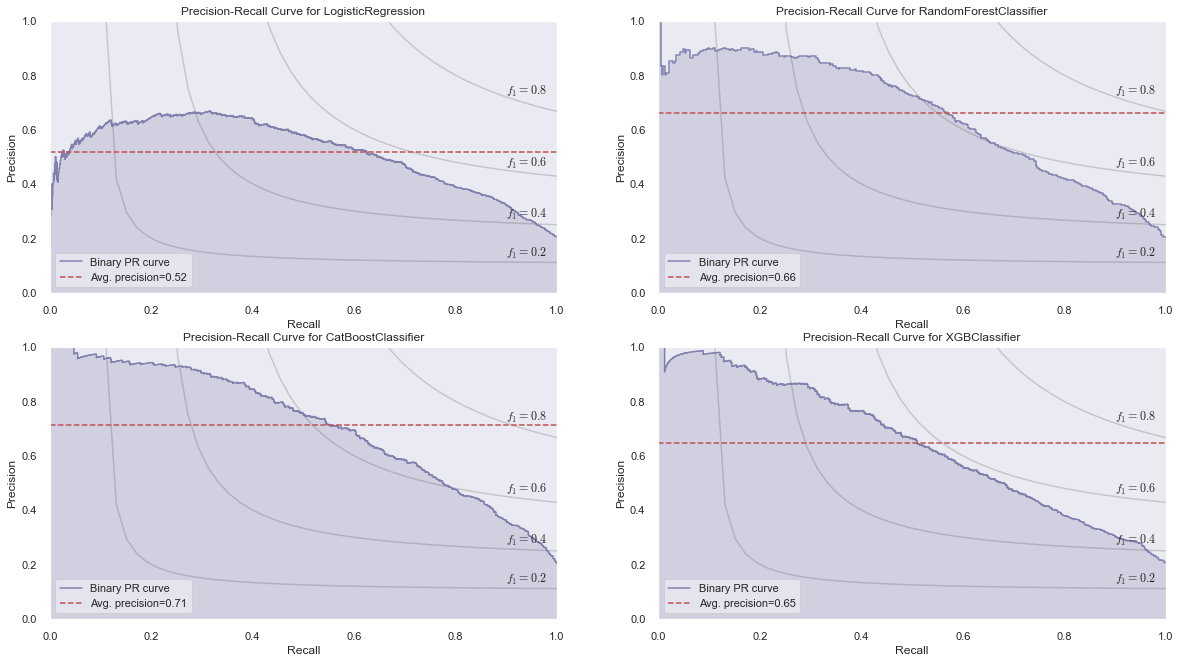

In [145]:
#Precision-recall ccurve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 11))

viz = PrecisionRecallCurve(reg, iso_f1_curves=True, ax=ax1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(rf, iso_f1_curves=True, ax=ax2)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

viz = PrecisionRecallCurve(wrap(cat_boost), iso_f1_curves=True, ax=ax3)
viz.fit(X_train_cat, y_train_cat)
viz.score(X_test_cat, y_test_cat)
viz.finalize()

viz = PrecisionRecallCurve(xgb, iso_f1_curves=True, ax=ax4)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.finalize()

### 4.2.6 Cross-validation score

The cross validation scores are very important metric because it **takes in consideration that train/test split is random** and it can give **slightly different results each time**. That being so, it splits the data in different ways and make different scores everytime. Here, it is divided in **12 parts** and two different **evaluation metrics**: ***balanced accuracy*** and ***F1 weighted***

**Conclusion**: the mean results of CatBoost algorithm are slightly better or very similar to Random Forest 

<img src="files/cross_val.png">

In [337]:
#Cross validation - Balanced Accuracy

cv_reg = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_reg = cross_val_score(reg, X, y, scoring='balanced_accuracy', cv=cv_reg, n_jobs=-1)
score_reg = pd.DataFrame(score_reg)

cv_rf = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_rf = cross_val_score(rf, X, y, scoring='balanced_accuracy', cv=cv_rf, n_jobs=-1)
score_rf = pd.DataFrame(score_rf)

cv_xgb = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_xgb = cross_val_score(xgb, X, y, scoring='balanced_accuracy', cv=cv_xgb, n_jobs=-1)
score_xgb = pd.DataFrame(score_xgb)

cv_cat = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_cat = cross_val_score(cat_boost, X_cat, y_cat, scoring='balanced_accuracy', cv=cv_cat, n_jobs=-1)
score_cat = pd.DataFrame(score_cat)

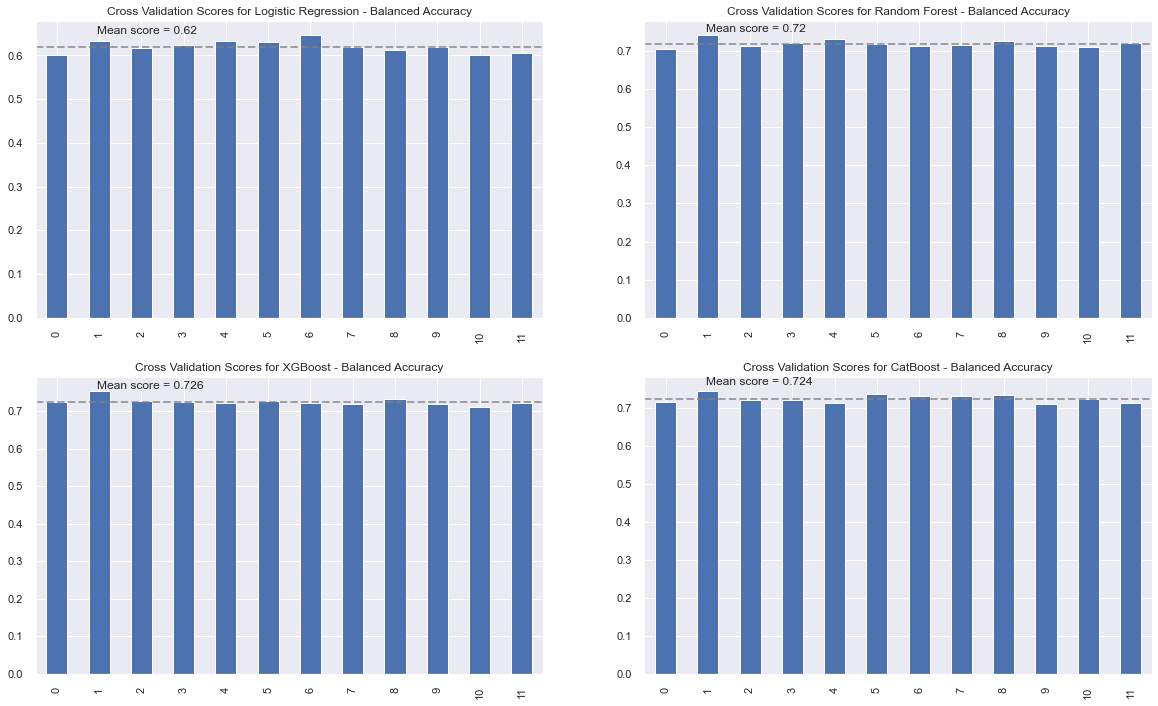

In [351]:
#Plot CV - Balanced Accuracy
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

y_reg = float(score_reg.mean().round(3))
score_reg.plot(kind='bar', legend=False, ax=ax1) 
ax1.axhline(y=y_reg, color='gray', linewidth=2, alpha=.7, ls='--')
ax1.text(0.95,0.65, 'Mean score = {}'.format(y_reg)) 
ax1.set_title('Cross Validation Scores for Logistic Regression - Balanced Accuracy')

y_rf = float(score_rf.mean().round(3))
score_rf.plot(kind='bar', legend=False, ax=ax2) 
ax2.axhline(y=y_rf, color='gray', linewidth=2, alpha=.7, ls='--')
ax2.text(0.95,0.75, 'Mean score = {}'.format(y_rf)) 
ax2.set_title('Cross Validation Scores for Random Forest - Balanced Accuracy')

y_xgb = float(score_xgb.mean().round(3))
score_xgb.plot(kind='bar', legend=False, ax=ax3) 
ax3.axhline(y=y_xgb, color='gray', linewidth=2, alpha=.7, ls='--')
ax3.text(0.95,0.76, 'Mean score = {}'.format(y_xgb)) 
ax3.set_title('Cross Validation Scores for XGBoost - Balanced Accuracy')

y_cat = float(score_cat.mean().round(3))
score_cat.plot(kind='bar', legend=False, ax=ax4) 
ax4.axhline(y=y_cat, color='gray', linewidth=2, alpha=.7, ls='--')
ax4.text(0.95,0.76, 'Mean score = {}'.format(y_cat)) 
ax4.set_title('Cross Validation Scores for CatBoost - Balanced Accuracy') ;

In [126]:
#Cross validation - F1 weighted

cv_reg = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_reg = cross_val_score(reg, X, y, scoring='f1_weighted', cv=cv_reg, n_jobs=-1)
score_reg = pd.DataFrame(score_reg)

cv_rf = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_rf = cross_val_score(rf, X, y, scoring='f1_weighted', cv=cv_rf, n_jobs=-1)
score_rf = pd.DataFrame(score_rf)

cv_xgb = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_xgb = cross_val_score(xgb, X, y, scoring='f1_weighted', cv=cv_xgb, n_jobs=-1)
score_xgb = pd.DataFrame(score_xgb)

cv_cat = StratifiedKFold(n_splits=12, random_state=123, shuffle=True)
score_cat = cross_val_score(cat_boost, X_cat, y_cat, scoring='f1_weighted', cv=cv_cat, n_jobs=-1)
score_cat = pd.DataFrame(score_cat)

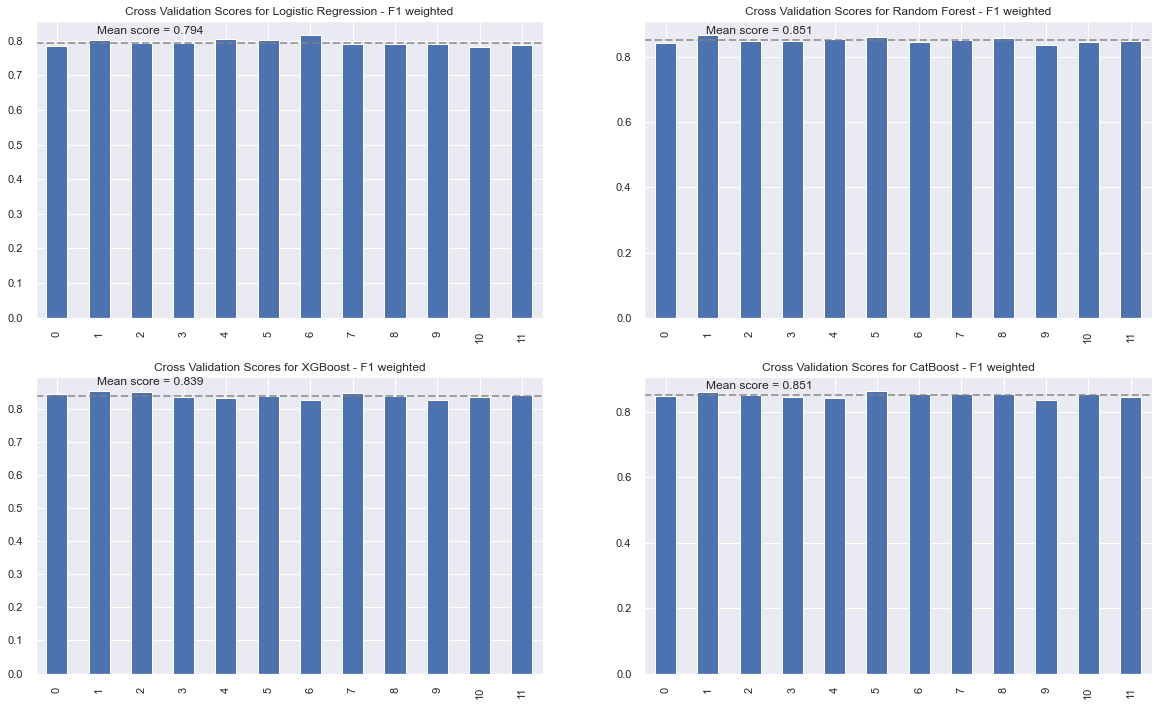

In [329]:
#Plot CV - F1 weighted
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

y_reg = float(score_reg.mean().round(3))
score_reg.plot(kind='bar', legend=False, ax=ax1) 
ax1.axhline(y=y_reg, color='gray', linewidth=2, alpha=.7, ls='--')
ax1.text(0.95,0.82, 'Mean score = {}'.format(y_reg)) 
ax1.set_title('Cross Validation Scores for Logistic Regression - F1 weighted')

y_rf = float(score_rf.mean().round(3))
score_rf.plot(kind='bar', legend=False, ax=ax2) 
ax2.axhline(y=y_rf, color='gray', linewidth=2, alpha=.7, ls='--')
ax2.text(0.95,0.87, 'Mean score = {}'.format(y_rf)) 
ax2.set_title('Cross Validation Scores for Random Forest - F1 weighted')

y_xgb = float(score_xgb.mean().round(3))
score_xgb.plot(kind='bar', legend=False, ax=ax3) 
ax3.axhline(y=y_xgb, color='gray', linewidth=2, alpha=.7, ls='--')
ax3.text(0.95,0.87, 'Mean score = {}'.format(y_xgb)) 
ax3.set_title('Cross Validation Scores for XGBoost - F1 weighted')

y_cat = float(score_cat.mean().round(3))
score_cat.plot(kind='bar', legend=False, ax=ax4) 
ax4.axhline(y=y_cat, color='gray', linewidth=2, alpha=.7, ls='--')
ax4.text(0.95,0.87, 'Mean score = {}'.format(y_cat)) 
ax4.set_title('Cross Validation Scores for CatBoost - F1 weighted') ;

### 4.2.7 Cumulative Gain Curve

This chart shows the **percentage of the overall number of cases a given category gained** by targeting some **percentage of the total number of cases**. The greater the **area between the baseline and the Cumulative Gain Curve**, the better the model 

**Conclusion**: the distance between the baseline and **CatBoost CGC curve is slightly better** than the other models 

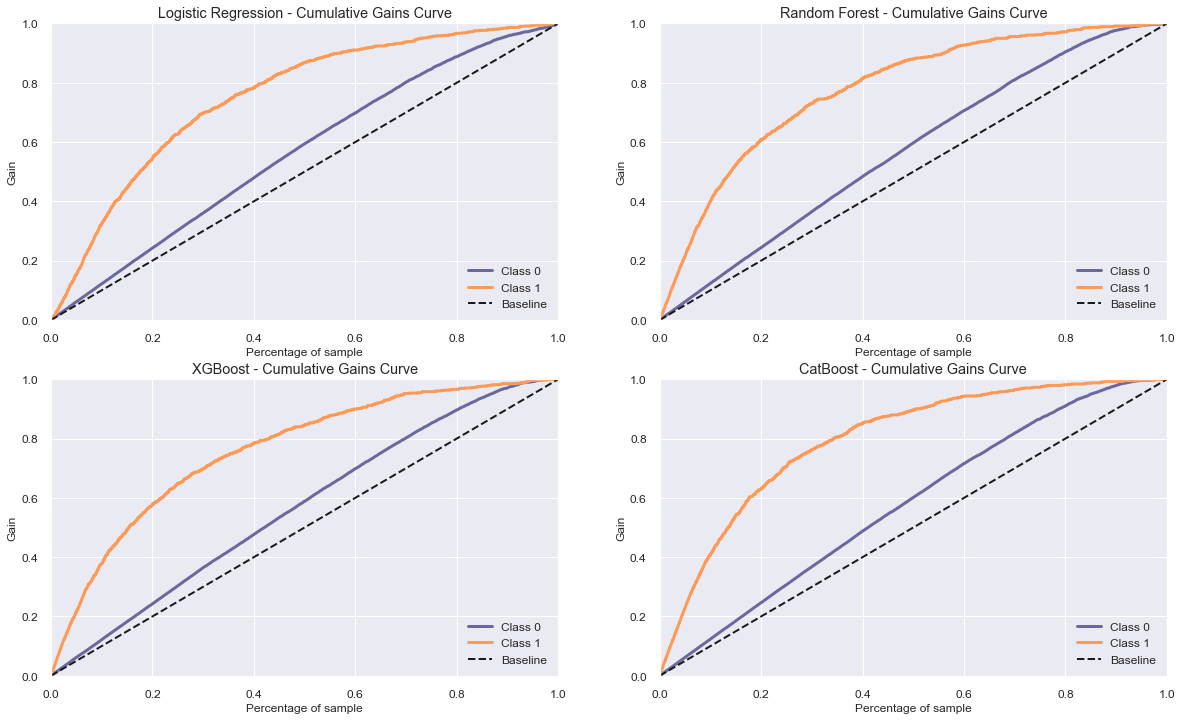

In [141]:
#Plot Cumulative Gain Curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

y_proba_reg = reg.predict_proba(X_test)
plot_cumulative_gain(y_test, y_proba_reg, title='Logistic Regression - Cumulative Gains Curve', ax=ax1)

y_proba_rf = rf.predict_proba(X_test)
plot_cumulative_gain(y_test, y_proba_rf, title='Random Forest - Cumulative Gains Curve', ax=ax2)

y_proba_xgb = xgb.predict_proba(X_test)
plot_cumulative_gain(y_test, y_proba_xgb, title='XGBoost - Cumulative Gains Curve', ax=ax3) 

y_proba_cat = cat_boost.predict_proba(X_test_cat)
plot_cumulative_gain(y_test_cat, y_proba_cat, title='CatBoost - Cumulative Gains Curve',ax=ax4)  ;

### 4.2.8 Lift Curve

The Lift Curve chart is derived from the Cumulative Gains chart. The values on the **y axis correspond to the ratio of the cumulative gain for each curve to the baseline**

**Conclusion**: *XGBoost* and *CatBoost* have the two best Lift curves

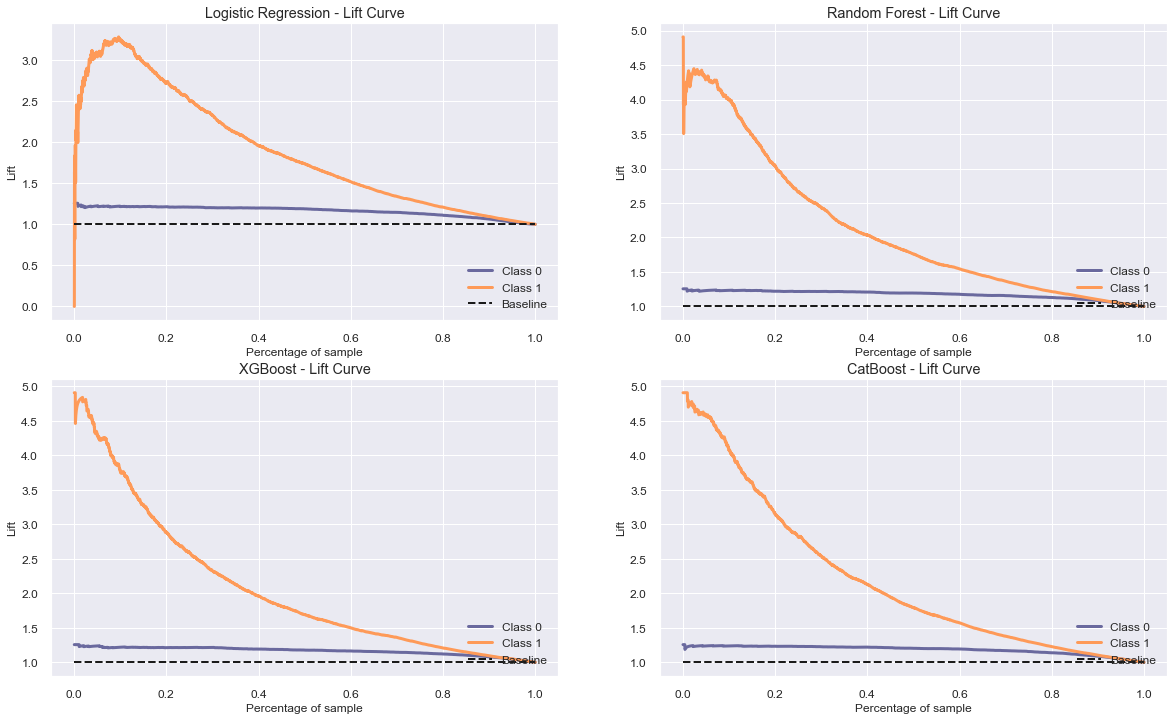

In [150]:
#Plot Lift Curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_lift_curve(y_test, y_proba_reg, title='Logistic Regression - Lift Curve', ax=ax1)

plot_lift_curve(y_test, y_proba_rf, title='Random Forest - Lift Curve', ax=ax2)

plot_lift_curve(y_test, y_proba_xgb, title='XGBoost - Lift Curve', ax=ax3) 

plot_lift_curve(y_test_cat, y_proba_cat, title='CatBoost - Lift Curve',ax=ax4)  ;

### 4.2.9 KS Statistic 

The ***Kolmogorov-Smirnov Statistic*** is used only in binary classification problems. It is the maximum difference between the cumulative **True Positive** and **False Positive rate**. It captures the **model's power of discriminating positive labels from a negative labels**. Therefore, the **greater the distance** between both curves, the better

**Conclusion**: *CatBoost* has the greater distance between the **True Positive** and **False Positive** curves

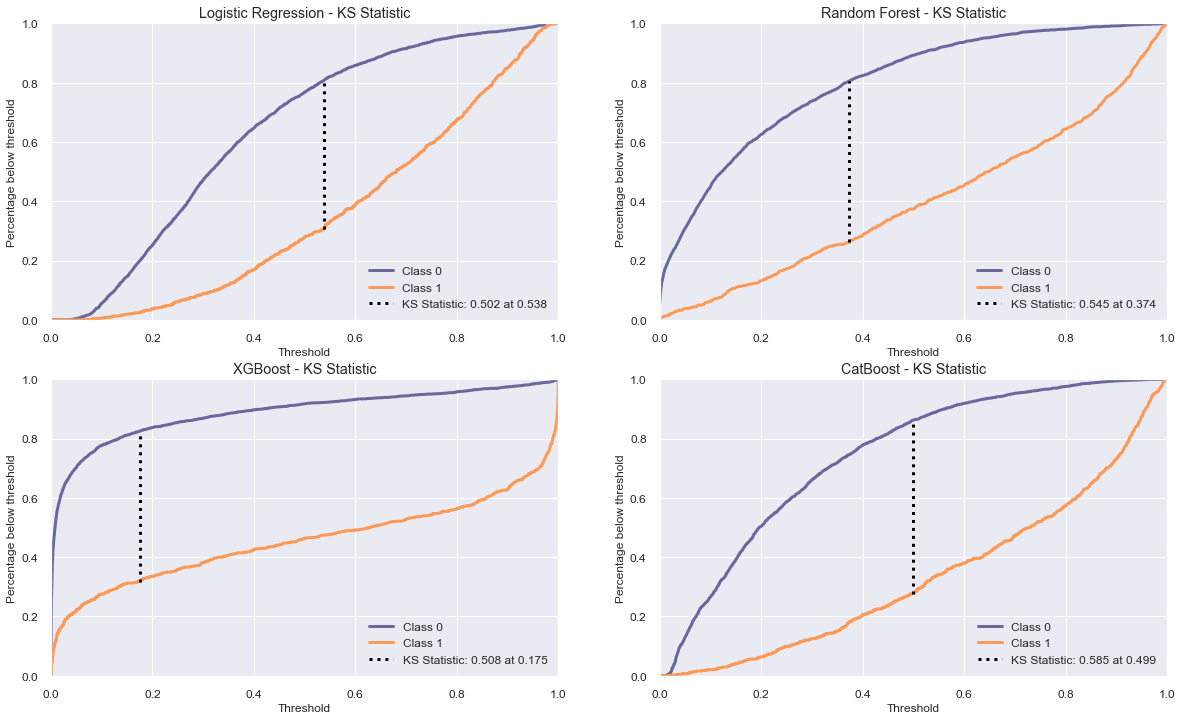

In [151]:
#Plot Lift Curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 12))

plot_ks_statistic(y_test, y_proba_reg, title='Logistic Regression - KS Statistic', ax=ax1)

plot_ks_statistic(y_test, y_proba_rf, title='Random Forest - KS Statistic', ax=ax2)

plot_ks_statistic(y_test, y_proba_xgb, title='XGBoost - KS Statistic', ax=ax3) 

plot_ks_statistic(y_test_cat, y_proba_cat, title='CatBoost - KS Statistic',ax=ax4)  ;

## 4.3 Hyperparameter fine tuning

Comparing the out of a box results, **CatBoost** is the Machine Learning algorithm that **worked better in this dataset**. Now, it's time to **fine tune** the hyperparameters aiming to **achieve the best result possible from the model**

### 4.3.1 GridSearchCV

Based on the previous analysis, the **chosen algorithm is the CatBoost Classifier**. Now, it is time to **fine tune its hyperparameters** to achieve the best performance possible. The strategy for the fine tuning is the **GridSearchCV** that tests **all the possible combinations** and gives the **best result**. The down side is that this calculation take a lot of computing capability

In [152]:
#See the parameters autimatically used in CatBoost out of the box 

cat_boost.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'BalancedAccuracy',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 500,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:

In [153]:
#GridSearchCV 

model = CatBoostClassifier()

df_categories = ['NumOfProducts', 'IsActiveMember', 'Tenure', 'geo_France', 'geo_Germany', 'geo_Spain', 'gender_Female', 'gender_Male']               

params = {'learning_rate':[0.05, 0.065, 0.07, 0.075, 0.08], 'cat_features':[df_categories], 'iterations':[400,500,600],'depth':[4, 5, 6, 7], 'eval_metric':['BalancedAccuracy'], 'verbose':[False], 'random_state':[123]}

grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='balanced_accuracy', n_jobs=-1, cv=12, refit=True, return_train_score=True)

grid_search.fit(X_train_cat, y_train_cat, eval_set=(X_test_cat, y_test_cat), use_best_model=True)

GridSearchCV(cv=12,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000028A5C5F1388>,
             n_jobs=-1,
             param_grid={'cat_features': [['NumOfProducts', 'IsActiveMember',
                                           'Tenure', 'geo_France',
                                           'geo_Germany', 'geo_Spain',
                                           'gender_Female', 'gender_Male']],
                         'depth': [4, 5, 6, 7],
                         'eval_metric': ['BalancedAccuracy'],
                         'iterations': [400, 500, 600],
                         'learning_rate': [0.05, 0.065, 0.07, 0.075, 0.08],
                         'random_state': [123], 'verbose': [False]},
             return_train_score=True, scoring='balanced_accuracy')

In [155]:
grid_search.best_score_

0.847133145342864

In [156]:
grid_search.best_params_

{'cat_features': ['NumOfProducts',
  'IsActiveMember',
  'Tenure',
  'geo_France',
  'geo_Germany',
  'geo_Spain',
  'gender_Female',
  'gender_Male'],
 'depth': 7,
 'eval_metric': 'BalancedAccuracy',
 'iterations': 400,
 'learning_rate': 0.05,
 'random_state': 123,
 'verbose': False}

### 4.3.2 Built final model 

Using the best parameters found in the GridSearchCV, this is the **final model** 

In [157]:
#Final model

df_categories = ['NumOfProducts', 'IsActiveMember', 'Tenure', 'geo_France', 'geo_Germany', 'geo_Spain', 'gender_Female', 'gender_Male']               

params = {'learning_rate': 0.05,'iterations':400, 'depth': 7,'random_seed':123, 'cat_features':df_categories, 'eval_metric':'BalancedAccuracy', 'verbose':False,'thread_count':-1}

model = CatBoostClassifier(**params)

model.fit(X_train_cat, y_train_cat, eval_set=(X_test_cat, y_test_cat), use_best_model=True, plot=False)


# 5.0 Business problem

The **budget for the action** plan to reduce the churn rate of clients is **$10.000,00**. The **business and marketing teams** worked together on a study and arrived at **three options**. It is now up to the **Data Science team choose which option maximaze ROI - Return on Investment**

The **strategy** is to **make a simulation** in the dataset with all the **three options** and choose the option which gives the **best results** 

The **revenue from clients** is calculated as follows:
- Clients above average: *returns **3%** of their Estimated Salary*
- Clients below average: *returns **5%** of their Estimated Salary*

The **mean** Estimated Salary is **$100.090,00**. For example, if the client's yearly Estimated salary is **$100.000,00** the bank has a **$100.000,00** x **5%** = ***$5.000,00*** yearly return per client 

<img src="files/options.png" width="9000">


## 5.1 Simulation -  Discount cupom of \$100

With a $100 discount and a $10.000,00 budget, the **top 100 clients with highest probabilities** would receive the cupom. Of the top 100 clients, ***97%*** of them were **True Churns** and ***03%*** were **False Churns**. When it comes to Estimated Salaries, ***55%*** of them were **above average** and ***45%*** of them were **below average**

Financial results:
- If **all True Churn clients** were recovered - *Potential recovery*: **$364.863,00**
- **False Churn** clients - *Waste*: **$300,00**

Scenario analysis:
- *Pessimistic*: **$255.404,00** recovered
- *Realistic*: **$291.890,00** recovered
- *Optmistic*: **$328.377,00** recovered
- *Mean of scenarios*: **$255.404,00** recovered


In [253]:
#Mean Estimated Salary

mean = df['EstimatedSalary'].mean().round()

mean

100090.0

In [228]:
#Predict probabilities

y_proba_cat = pd.DataFrame(model.predict_proba(X_test_cat))

In [229]:
#Transform into DataFrame

y_test_cat = y_test_cat.to_frame()

In [230]:
#Get the Estimated Salary information

bal = X_test_cat[['EstimatedSalary']]

bal['EstimatedSalary'] = mms.inverse_transform(bal[['EstimatedSalary']].values)

exited_bal = pd.concat((y_test_cat, bal), axis=1)

In [231]:
#Merge DataFrames

exited_bal.reset_index(drop=True, inplace=True)

pred = pd.concat((exited_bal, y_proba_cat), axis=1)

pred.drop([0], axis=1, inplace=True)

In [232]:
#Sort by probability to churn

pred.sort_values(by=1, inplace=True, ascending=False)

In [233]:
#Get the top 100 probabilities

top_100 = pred.head(100)

In [234]:
#Proportion of sucess - percentage

a = top_100['Exited'].value_counts(normalize=True)*100

a.to_frame()

Exited
1    97.0
0     3.0

In [235]:
#Proportion of sucess - absolute values

false_churn = top_100['Exited'].value_counts()

false_churn.to_frame()

Exited
1      97
0       3

In [254]:
#Create above average column

top_100['above_average'] = top_100['EstimatedSalary']

top_100['above_average'] = top_100['above_average'].apply(lambda x: 'yes' if x>=mean else 'no')

In [255]:
#Above average overall statistics

a = top_100.pivot_table(values='Exited', columns='above_average', aggfunc='count')

a

above_average  no  yes
Exited         45   55

In [238]:
#Create DataFrame for true churns

true_100 = top_100[top_100['Exited'] == 1]

true_100.shape

(97, 4)

In [239]:
#Calculate the estimate return for each client 

true_100['100_return'] = true_100['EstimatedSalary']

true_100['100_return'] = true_100['100_return'].apply(lambda x: x*0.03 if x>=mean else x*0.05)

In [240]:
#Results - if 100% of clients returned

return_100 = (true_100['100_return'].sum()).round()

waste_100 = false_churn[0] * 100

print('If all churn clients were recovered: $', return_100)
print('Clients that were not actual churn (waste): $',waste_100)

If all churn clients were recovered: $ 364863.0
Clients that were not actual churn (waste): $ 300


In [241]:
#Scenario analysis

#Pessimistic
p_recovered = (return_100 * 0.7).round()
print('Pessimistic - recovered: $', p_recovered)

#Realistic
r_recovered = (return_100 * 0.8).round()
print('Realistic - recovered: $', r_recovered)

#Optmistic
o_recovered = (return_100 * 0.9).round()
print('Optmistic - recovered: $', o_recovered)

#Mean
mean = ((p_recovered + p_recovered + p_recovered) / 3).round()
print('Mean of scenarios - recovered: $', mean)

Pessimistic - recovered: $ 255404.0
Realistic - recovered: $ 291890.0
Optmistic - recovered: $ 328377.0
Mean of scenarios - recovered: $ 255404.0


## 5.2 Simulation -  Discount cupom of \$50

With a $50 discount and a $10.000,00 budget, the **top 200 clients with highest probabilities** would receive the cupom. Of the top 200 clients, ***94%*** of them were **True Churns** and ***6%*** were **False Churns**. When it comes to Estimated Salaries, ***59,5%*** of them were **above average** and ***40,5%*** of them were **below average**, the same percentage as the top 100 clients

Financial results:
- If **all True Churn clients** were recovered - *Potential recovery*: **$1.129.669,00**
- **False Churn** clients - *Waste*: **$600,00**

Scenario analysis:
- *Pessimistic*: **$451.868,00** recovered
- *Realistic*: **$564.834,00** recovered
- *Optmistic*: **$677.801,00** recovered
- *Mean of scenarios*: **$564.834,00** recovered 


In [242]:
#Get the top 200 probabilities

top_200 = pred.head(200)

In [243]:
#Proportion of sucess - percentage

a = top_200['Exited'].value_counts(normalize=True)*100

a.to_frame()

Exited
1    94.0
0     6.0

In [244]:
#Proportion of sucess - absolute values

false_churn = top_200['Exited'].value_counts()

false_churn.to_frame()

Exited
1     188
0      12

In [256]:
#Create above average column

top_200['above_average'] = top_200['EstimatedSalary']

top_200['above_average'] = top_200['above_average'].apply(lambda x: 'yes' if x>=mean else 'no')

In [257]:
#Above average overall statistics

a = top_200.pivot_table(values='Exited', columns='above_average', aggfunc='count')

a

above_average  no  yes
Exited         81  119

In [247]:
#Create DataFrame for true churns

true_200 = top_200[top_200['Exited'] == 1]

true_200.shape

(188, 4)

In [248]:
#Calculate the estimate return for each client 

true_200['200_return'] = true_200['EstimatedSalary']

true_200['200_return'] = true_200['200_return'].apply(lambda x: x*0.03 if x>=mean else x*0.05)

In [249]:
#Results - if 100% of clients returned

return_200 = (true_200['200_return'].sum()).round()

waste_200 = false_churn[0] * 50

print('If all churn clients were recovered: $', return_200)
print('Clients that were not actual churn (waste): $',waste_200)

If all churn clients were recovered: $ 1129669.0
Clients that were not actual churn (waste): $ 600


In [250]:
#Scenario analysis

#Pessimistic
p_recovered = (return_200 * 0.4).round()
print('Pessimistic - recovered: $', p_recovered)

#Realistic
r_recovered = (return_200 * 0.5).round()
print('Realistic - recovered: $', r_recovered)

#Optmistic
o_recovered = (return_200 * 0.6).round()
print('Optmistic - recovered: $', o_recovered)

#Mean
mean = ((p_recovered + r_recovered + o_recovered) / 3).round()
print('Mean of scenarios - recovered: $', mean)

Pessimistic - recovered: $ 451868.0
Realistic - recovered: $ 564834.0
Optmistic - recovered: $ 677801.0
Mean of scenarios - recovered: $ 564834.0


## 5.3 Simulation -  Discount cupom of \$25

With a $50 discount and a $10.000,00 budget, the **top 400 clients with highest probabilities** would receive the cupom. Of the top 400 clients, ***82,25%*** of them were **True Churns** and ***17,75%*** were **False Churns**. When it comes to Estimated Salaries, ***59,25%*** of them were **above average** and ***40,75%*** of them were **below average**

Financial results:
- If **all True Churn clients** were recovered - *Potential recovery*: **$1.314.779,00**
- **False Churn** clients - *Waste*: **$1.775,00**

Scenario analysis:
- *Pessimistic*: **$338.901,00** recovered
- *Realistic*: **$451.868,00** recovered
- *Optmistic*: **$564.834,00** recovered
- *Mean of scenarios*: **$451.868,00** recovered 


In [258]:
#Get the top 400 probabilities

top_400 = pred.head(400)

In [259]:
#Proportion of sucess - percentage

a = top_400['Exited'].value_counts(normalize=True)*100

a.to_frame()

Exited
1   82.25
0   17.75

In [260]:
#Proportion of sucess - absolute values

false_churn = top_400['Exited'].value_counts()

false_churn.to_frame()

Exited
1     329
0      71

In [261]:
#Create above average column

top_400['above_average'] = top_400['EstimatedSalary']

top_400['above_average'] = top_400['above_average'].apply(lambda x: 'yes' if x>=mean else 'no')

In [262]:
#Above average overall statistics

a = top_400.pivot_table(values='Exited', columns='above_average', aggfunc='count')

a

above_average   no  yes
Exited         163  237

In [263]:
#Create DataFrame for true churns

true_400 = top_400[top_400['Exited'] == 1]

true_400.shape

(329, 4)

In [264]:
#Calculate the estimate return for each client 

true_400['400_return'] = true_400['EstimatedSalary']

true_400['400_return'] = true_400['400_return'].apply(lambda x: x*0.03 if x>=mean else x*0.05)

In [265]:
#Results - if 100% of clients returned

return_400 = (true_400['400_return'].sum()).round()

waste_400 = false_churn[0] * 25

print('If all churn clients were recovered: $', return_400)
print('Clients that were not actual churn (waste): $',waste_400)

If all churn clients were recovered: $ 1314779.0
Clients that were not actual churn (waste): $ 1775


In [266]:
#Scenario analysis

#Pessimistic
p_recovered = (return_200 * 0.3).round()
print('Pessimistic - recovered: $', p_recovered)

#Realistic
r_recovered = (return_200 * 0.4).round()
print('Realistic - recovered: $', r_recovered)

#Optmistic
o_recovered = (return_200 * 0.5).round()
print('Optmistic - recovered: $', o_recovered)

#Mean
mean = ((p_recovered + r_recovered + o_recovered) / 3).round()
print('Mean of scenarios - recovered: $', mean)

Pessimistic - recovered: $ 338901.0
Realistic - recovered: $ 451868.0
Optmistic - recovered: $ 564834.0
Mean of scenarios - recovered: $ 451868.0


## 5.4 Conclusion

To calculate the Return of Investment (ROI), we'll use the **Mean Return** of all the Scenarios values. The ROI for each of the three options are:

- **$100** ROI: **2554%** 

- **$50** ROI: **5648%**  

- **$25** ROI: **4519%** 


> The cupom with **$50 is going to be the chosen option**, because it **maximazes the Return of Investment** which is ***5648%***

<img src="files/roi.png" width="600">



In [267]:
#Mean return 

cupom_100 = 255404
cupom_50 = 564834
cupom_25 = 451868

In [284]:
#ROI calculation

ROI_100 = round((cupom_100 / 10000) * 100)

ROI_50 = round((cupom_50 / 10000) * 100)

ROI_25 = round((cupom_25 / 10000) * 100)

print('ROI $100:', ROI_100)
print('ROI $50:', ROI_50)
print('ROI $25:', ROI_25)

ROI $100: 2554
ROI $50: 5648
ROI $25: 4519
